<a href="https://colab.research.google.com/github/NCAR-NinaOmani/BOR_S2S_Precipitation_Forecast_NCAR/blob/main/B_Categorical_S2S_PRCP_Forecast_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **S2S Precipitation Forecast Evaluation using Logistic and Linear Regression**

This notebook evaluates the skill of categorical S2S precipitation forecasts across the Southwest U.S. using various predictors. Forecasts are assessed by comparing predicted tercile categories (dry, normal, wet) against observed precipitation using statistical metrics such as the Brier Skill Score (BSS) and Ranked Probability Skill Score (RPSS). The analysis focuses on different seasons, lead times, and regions (AZ_West, AZ_East, NM_South, NM_North), using models that incorporate weather types (WT), ENSO indices, and other climate variables. \
This notebook builds on the original R code and methodology developed by Erin Towler for weather type (WT) predictors. We translated the code into Python and expanded it to include additional climate predictors.

**Input file:** \
`Predictors_filled.csv` \
**Outputs:** \
`gof_training_hindcast_final.csv` \
`ecmwf_prediction_final.csv`


*Nina Omani* \
*4/11/2025*


In [6]:
!pip install pandas numpy scikit-learn scipy matplotlib
!pip install gdown

In [7]:
import os
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.formula.api as smf
from matplotlib import patches as mpatches
from matplotlib.lines import Line2D
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

**1. Initialization**

In [8]:
# Define a region
regions = ["AZ_West", "AZ_East", "NM_South", "NM_North"]
# Define the custom season order
custom_season_order = ['Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                       'JJ', 'JA', 'AS', 'SO',
                       'JJA', 'JAS', 'ASO', 'JASO', 'JJASO']

# Define single-month and aggregated-month season sets
single_month_seasons = {'Jun', 'Jul', 'Aug', 'Sep', 'Oct'}
aggregated_month_seasons = set(custom_season_order) - single_month_seasons

**2. Data Loading and Cleaning** \
The `Predictors.csv` file is loaded to extract predictor variables (e.g., ENSO indices, antecedent conditions). \
Missing values are filled based on a mapping of aggregated seasons to base months using logic. \



In [9]:
Predictors_data = pd.read_csv("Predictors_filled.csv")

**3. Modeling Section**



*   **Training (1993-2018):**
The models are trained using reanalysis data nd observed precipitation of 1993-2018.
Data is normalized for predictors and target variables (avgPCP_mmDay) to ensure consistent scaling during model training.
*   **Hindcast Evaluation (1993–2018):** \
Hindcast predictions are made using models trained on reanalysis data (obs) and evaluated on forecast data (for). Predictors are normalized and used to train models like LinearRegression. Data is normalized for predictors (by region, season and lead month) and target variables (avgPCP_mmDay) to ensure consistent scaling.
*   **Predict ECMWF forecasts:** \
Out-of-sample prediction evaluation (for years > 2018)

In [10]:
# Load data
Predictors_filled = Predictors_data.copy()
Predictors_filled["season"] = pd.Categorical(Predictors_filled["season"], categories=custom_season_order, ordered=True)
min_year, max_year = 1993, 2018 # For prediction

**4. Multi-Linear Regression (MLR)** \
Models with different combinations of predictors are defined. \
Training metrics (RMSE_train and R²_MLR_train) and hindcast metrics (RMSE_ECMWF and R²_ECMWF)  are computed. \
**Output:** \
`GOF_training_results.csv` and `GOF_ECMWF_hindcast_results.csv`.

In [11]:
# Define multi-predictor models
combined_model_specs = {
    "multi_linear1": ["sumMonsoon_obs", "sumDry_obs"],
    "multi_linear2": ["sumq_obs", "antecedent_3m_obs"],
    "multi_linear3": ["sumMonsoon_obs", "sumDry_obs", "antecedent_3m_obs"]
}

In [12]:
ecmwf_gof = []
gof_training = []
ecmwf_results = []


for model_key, predictors in combined_model_specs.items():
    df_model = Predictors_filled[["region", "season", "year", "lead_month", "avgPCP_mmDay"] + predictors].dropna()

    for region in df_model["region"].unique():
        for season in df_model["season"].unique():
            df_train = df_model[
                (df_model["region"] == region) &
                (df_model["season"] == season) &
                (df_model["year"] >= min_year) & (df_model["year"] <= max_year)
            ].copy()

            if df_train.empty:
                continue

            safe_names = {p: p.replace(".", "_") for p in predictors}
            norm_means = {p: df_train[p].mean() for p in predictors}
            norm_stds = {p: df_train[p].std() for p in predictors}

            skip = False
            for p in predictors:
                if pd.isna(norm_stds[p]) or norm_stds[p] == 0:
                    skip = True
                    break
                df_train[f"x_{safe_names[p]}"] = (df_train[p] - norm_means[p]) / norm_stds[p]
            if skip:
                continue

            x_cols = [f"x_{safe_names[p]}" for p in predictors]
            y_mean = df_train["avgPCP_mmDay"].mean()
            y_std = df_train["avgPCP_mmDay"].std()
            df_train["y"] = (df_train["avgPCP_mmDay"] - y_mean) / y_std

            model = LinearRegression()
            model.fit(df_train[x_cols], df_train["y"])

            y_pred = model.predict(df_train[x_cols])
            y_pred_rescaled = y_pred * y_std + y_mean
            r2 = r2_score(df_train["avgPCP_mmDay"], y_pred_rescaled)

            # Predictions already computed above: y_pred_rescaled
            rmse_train = np.sqrt(mean_squared_error(df_train["avgPCP_mmDay"], y_pred_rescaled))
            rmse_clim = np.sqrt(mean_squared_error(df_train["avgPCP_mmDay"], [y_mean] * len(df_train)))

            # Append RMSE (model) and RMSE_clim (baseline) to training GOF
            # Append training R²
            gof_training.append({
                'region': region,
                'season': season,
                'model': "MLR",
                'lead_month': "NA",
                'statlong': 'R2_MLR_train',
                'stat': 'R2',
                'value': r2,
                'stat_obs': r2,
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                "predictor": "+".join(p for p in predictors),
                'xval': False,
                'xnormMean': str({p: round(norm_means[p], 4) for p in predictors}),
                'xnormSD': str({p: round(norm_stds[p], 4) for p in predictors}),
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': model.intercept_,
                'coef2': model.coef_[0] if len(model.coef_) > 0 else 0.0,
                'coef3': model.coef_[1] if len(model.coef_) > 1 else 0.0,
            })

            # Append training RMSE and climatology RMSE
            gof_training.extend([
                {
                    'region': region,
                    'season': season,
                    'model': "MLR",
                    'lead_month': "NA",
                    'statlong': 'RMSE_train',
                    'stat': 'RMSE',
                    'value': rmse_train,
                    'predictor': "+".join(p for p in predictors),
                },
                {
                    'region': region,
                    'season': season,
                    'model': "climatology",
                    'lead_month': "NA",
                    'statlong': 'RMSE_clim',
                    'stat': 'RMSE',
                    'value': rmse_clim,
                    'predictor': "+".join(p for p in predictors),
                }
            ])

            # --- Hindcast ---
            df_hind = Predictors_filled[
                (Predictors_filled["region"] == region) & (Predictors_filled["season"] == season) &
                (Predictors_filled["year"] >= min_year) & (Predictors_filled["year"] <= max_year)
            ].copy()

            for lead in sorted(df_hind["lead_month"].dropna().unique()):
                df_lead = df_hind[df_hind["lead_month"] == lead].copy()
                predictor_for = [p.replace("_obs", "_for") for p in predictors]
                df_lead = df_lead.dropna(subset=predictor_for + ["avgPCP_mmDay"])
                if df_lead.empty:
                    continue

                norm_means_for = {}
                norm_stds_for = {}
                for_norm = pd.DataFrame(index=df_lead.index)

                skip_lead = False
                for p in predictors:
                    p_for = p.replace("_obs", "_for")
                    mean = df_lead[p_for].mean()
                    std = df_lead[p_for].std()
                    if pd.isna(std) or std == 0:
                        skip_lead = True
                        break
                    norm_means_for[p_for] = mean
                    norm_stds_for[p_for] = std
                    for_norm[f"x_{safe_names[p]}"] = (df_lead[p_for] - mean) / std
                if skip_lead:
                    continue

                y_pred = model.predict(for_norm[x_cols])
                y_pred_rescaled = y_pred * y_std + y_mean
                r2_hind = r2_score(df_lead["avgPCP_mmDay"], y_pred_rescaled)

                # Compute RMSE for hindcast
                rmse_hind = np.sqrt(mean_squared_error(df_lead["avgPCP_mmDay"], y_pred_rescaled))
                rmse_clim_lead = np.sqrt(mean_squared_error(df_lead["avgPCP_mmDay"], [y_mean] * len(df_lead)))


                # Append R² for ECMWF hindcast
                ecmwf_gof.append({
                    "region": region,
                    "season": season,
                    "model": "MLR",
                    "lead_month": lead,
                    "statlong": f'R2_ECMWF_lead{lead}',
                    "stat": "R2",
                    "value": r2_hind,
                    "stat_obs": r2,
                    "stat_obs_xval": "NA",
                    "detrend": False,
                    "norm": True,
                    "predictor": "+".join(p.replace(".obs", ".for") for p in predictors),
                    "xval": False,
                    "xnormMean": str({p: round(norm_means_for[p.replace("_obs", "_for")], 4) for p in predictors}),
                    "xnormSD": str({p: round(norm_stds_for[p.replace("_obs", "_for")], 4) for p in predictors}),
                    "ynormMean": y_mean,
                    "ynormSD": y_std,
                    "coef1": model.intercept_,
                    "coef2": model.coef_[0] if len(model.coef_) > 0 else 0.0,
                    "coef3": model.coef_[1] if len(model.coef_) > 1 else 0.0
                })

                # Append RMSE (model and climatology) for ECMWF hindcast
                ecmwf_gof.extend([
                    {
                        "region": region,
                        "season": season,
                        "model": "MLR",
                        "lead_month": lead,
                        "statlong": f'RMSE_ECMWF_lead{lead}',
                        "stat": "RMSE",
                        "value": rmse_hind,
                        "predictor": "+".join(p.replace("_obs", "_for") for p in predictors),
                    },
                    {
                        "region": region,
                        "season": season,
                        "model": "climatology",
                        "lead_month": lead,
                        "statlong": f'RMSE_clim_lead{lead}',
                        "stat": "RMSE",
                        "value": rmse_clim_lead,
                        "predictor": "+".join(p.replace("_obs", "_for") for p in predictors),
                    }
                ])
                for i, row in enumerate(df_lead.itertuples(index=False)):
                  ecmwf_results.append({
                      "region": region,
                      "season": season,
                      "model": "MLR",
                      "predictor": "+".join(predictor_for),  # Convert list to string like "sumMonsoon.for+sumDry.for"
                      "predictor_value": [float(v) for v in df_lead.iloc[i][predictor_for].values],
                      "year": row.year,
                      "lead_month": row.lead_month,
                      "type": "ecmwf-hindcast",
                      "observed": row.avgPCP_mmDay,
                      "predicted": y_pred_rescaled[i],
                })


# Convert lists of dictionaries to DataFrames
gof_training_df = pd.DataFrame(gof_training)
gof_hindcast_df = pd.DataFrame(ecmwf_gof)

# Save to CSV
gof_training_df.to_csv("GOF_training_results.csv", index=False)
gof_hindcast_df.to_csv("GOF_ECMWF_hindcast_results.csv", index=False)

ecmwf_MLR = pd.DataFrame(ecmwf_results)
ecmwf_path = "ecmwf_predictionsMLR.csv"
ecmwf_MLR.to_csv(ecmwf_path, index=False)


**5. SLR, Binomial, and Proportional Odds** \
Perform logistic regression and ordered regression for binomial and multinomial categories beside Single Linear Regression (SLR).
Evaluation metrics includes RMSE, RPSS and BSS. \
**Output:** \
Forecasted values are saved in `ecmwf_predictionsMLR.csv`. \
Statistical summaries for binomial and multinomial regressions are saved in `ecmwf_gof.csv`


In [13]:
predictors = ["sumMonsoon_obs", "sumDry_obs", "sumtclw_obs", "sumq_obs", "sumtprate_obs","ant_soi_obs","ant_mei_obs","ant_dsst3.4_obs","antecedent_1m_obs","antecedent_2m_obs","antecedent_3m_obs"]

In [14]:
linear_result = []
obs_fit_data = []
ecmwf_results = []
ecmwf_gof = []
processed_models = set()

for predictor_obs in predictors:
    # Drop NaNs only for this specific predictor and avgPCP_mmDay
    obs_df = Predictors_filled[["region", "season", "year", "avgPCP_mmDay", predictor_obs]].dropna().drop_duplicates()


    for region in obs_df["region"].unique():  # region = "AZ_East"    season = "SO"
        for season in obs_df["season"].unique():

            key = (region, season, predictor_obs)
            if key in processed_models:
                continue
            processed_models.add(key)

            df_train = obs_df[
                (obs_df["region"] == region) &
                (obs_df["season"] == season) &
                (obs_df["year"] >= min_year) &
                (obs_df["year"] <= max_year)
            ].copy()

            if df_train.empty:
                continue

            # Normalize
            x_mean = df_train[predictor_obs].mean()
            x_std = df_train[predictor_obs].std()
            y_mean = df_train["avgPCP_mmDay"].mean()
            y_std = df_train["avgPCP_mmDay"].std()

            df_train["x"] = (df_train[predictor_obs] - x_mean) / x_std
            df_train["y"] = (df_train["avgPCP_mmDay"] - y_mean) / y_std

            if df_train["x"].isna().any() or df_train["y"].isna().any():
                continue

            model = LinearRegression()
            model.fit(df_train[["x"]], df_train["y"])

            df_train["y_pred"] = model.predict(df_train[["x"]])
            df_train["y_pred_rescaled"] = df_train["y_pred"] * y_std + y_mean

            for _, row in df_train.iterrows():
                obs_fit_data.append({
                    "region": region, "season": season, "year": row["year"], "predictor": predictor_obs,
                    "predictor_value": row[predictor_obs], "observed": row["avgPCP_mmDay"],
                    "predicted": row["y_pred"], "predicted_rescaled": row["y_pred_rescaled"]
                })


            # Compute model performance metrics (in-sample)
            y_obs = df_train["avgPCP_mmDay"].values
            y_pred_insample = df_train["y_pred_rescaled"].values
            y_clim = np.mean(y_obs)

            mse_lm = mean_squared_error(y_obs, y_pred_insample)
            mse_clim = mean_squared_error(y_obs, np.full_like(y_obs, y_clim))
            mae_lm = mean_absolute_error(y_obs, y_pred_insample)
            mae_clim = mean_absolute_error(y_obs, np.full_like(y_obs, y_clim))
            rmse_clim = np.sqrt(mse_clim)
            rmse_lm = np.sqrt(mse_lm)
            r2_lm = r2_score(y_obs, y_pred_insample)
            skill_improvement = 1 - mse_lm / mse_clim if mse_clim != 0 else np.nan

            # Calculate the quantiles
            Q50 = df_train['avgPCP_mmDay'].median()
            Q33 = df_train['avgPCP_mmDay'].quantile(0.3333)
            Q66 = df_train['avgPCP_mmDay'].quantile(0.6666)

            y_n = len(df_train['y'])

            # Compute quantiles
            zQuant = df_train['y'].quantile([0.3333, 0.6666])
            T1 = zQuant.iloc[0]  # Q33
            T2 = zQuant.iloc[1]  # Q66

            # Median
            zMed = df_train['y'].median()

            # Create binomial response initialized with a placeholder (not necessary in pandas but included for similarity)
            y_binom = np.full(y_n, -999)

            # Assign categories based on the median
            y_binom[df_train['y'] <= zMed] = 0
            y_binom[df_train['y'] > zMed] = 1

            # Compute proportions
            p1_clim_bi = np.sum(y_binom == 0) / y_n
            p2_clim_bi = np.sum(y_binom == 1) / y_n

            # Display category proportions
            binomial_summary = pd.DataFrame(
                [[round(p1_clim_bi, 2), round(p2_clim_bi, 2)]],
                columns=["Cat0", "Cat1"]
            )

            print("##########################binomial_summary###########################")
            print(binomial_summary)

            # Create multinomial response initialized with a placeholder
            y_log = np.full(y_n, -999)

            # Assign categories based on thresholds T1 and T2
            y_log[df_train['y'] <= T1] = 1       # Cat 1
            y_log[(df_train['y'] > T1) & (df_train['y'] < T2)] = 2  # Cat 2
            y_log[df_train['y'] >= T2] = 3       # Cat 3

            # Ensure integer type for comparison
            y_log = y_log.astype(int)

            # Compute proportions
            p1_clim = np.sum(y_log == 1) / y_n
            p2_clim = np.sum(y_log == 2) / y_n
            p3_clim = np.sum(y_log == 3) / y_n
            climo = [p1_clim, p2_clim, p3_clim]

            # Display category proportions
            multinomial_summary = pd.DataFrame(
                [[round(p1_clim, 2), round(p2_clim, 2), round(p3_clim, 2)]],
                columns=["Cat1", "Cat2", "Cat3"]
            )

            print("##########################multinomial_summary###########################")
            print(multinomial_summary)
            print("########################################################################")

            # Add binomial and multinomial response columns to the DataFrame
            df_train['y_binom'] = y_binom
            df_train['y_multi'] = y_log

            # Fit logistic regression model (binomial family)
            vglm_binom = smf.logit(formula='y_binom ~ x', data=df_train).fit()

            print(vglm_binom.summary())

            from statsmodels.miscmodels.ordinal_model import OrderedModel

            # Ensure y_multi is treated as an ordered categorical variable (1 < 2 < 3)
            df_train['y_multi'] = pd.Categorical(df_train['y_multi'], ordered=True)

            # Fit proportional odds model (ordinal logistic regression)
            vglm_propodds = OrderedModel(
                df_train['y_multi'],
                df_train[['x']],   # predictors
                distr='logit'            # logit link matches 'propodds' in R
            ).fit(method='bfgs')


            print(vglm_propodds.summary())

            # Get fitted probabilities from the binomial logistic model
            yhat_binom = vglm_binom.predict()  # This returns predicted probabilities for y_binom = 1

            # Brier Score
            B_score = np.sum((yhat_binom - df_train['y_binom']) ** 2) / y_n
            B_score_clim = np.sum((p2_clim_bi - df_train['y_binom']) ** 2) / y_n
            BSS = 1 - (B_score / B_score_clim)
            BSS_obs = BSS

            # RPSS
            pred_probs = vglm_propodds.predict(which='prob')
            y_log = df_train['y_multi'].astype(int).values - 1

            rps = 0.0
            rpsc = 0.0
            for i in range(len(y_log)):
                obs = np.zeros(3)
                obs[y_log[i]] = 1
                rps += np.sum((obs - pred_probs[i]) ** 2)
                rpsc += np.sum((obs - climo) ** 2)

            rpss = 1 - (rps / rpsc)
            rpss_obs = rpss
            print("✅ RPSS =", round(rpss, 4))

            # Add RMSE for training
            ecmwf_gof.append({
                'region': region,
                'season': season,
                'model': 'SLR',
                'lead_month': "NA",
                'statlong': 'RMSE_SLR_train',
                'stat': 'RMSE',
                'value': np.sqrt(mse_lm),
                'stat_obs': np.sqrt(mse_lm),
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                'predictor': predictor_obs.replace('_obs', ''),
                'xval': False,
                'xnormMean': x_mean,
                'xnormSD': x_std,
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': model.intercept_,
                'coef2': model.coef_[0],
                'coef3': 0.0,
                'Q50_mmDay': Q50,
                'Q33_mmDay': Q33,
                'Q66_mmDay': Q66
            })

            # Add RMSE for climatology (training)
            ecmwf_gof.append({
                'region': region,
                'season': season,
                'model': 'climatology',
                'lead_month': "NA",
                'statlong': 'RMSE_clim_train',
                'stat': 'RMSE',
                'value': np.sqrt(mse_clim),
                'stat_obs': np.sqrt(mse_clim),
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                'predictor': predictor_obs.replace('_obs', ''),
                'xval': False,
                'xnormMean': x_mean,
                'xnormSD': x_std,
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': 0.0,
                'coef2': 0.0,
                'coef3': 0.0,
                'Q50_mmDay': Q50,
                'Q33_mmDay': Q33,
                'Q66_mmDay': Q66
              })

            linear_result.append({
                'region': region,
                'season': season,
                'model': 'SLR',
                'lead_month': "NA",
                'statlong': 'R2_SLR_train',
                'stat': 'R2',
                'value': r2_lm,
                'stat_obs': r2_lm,
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                'predictor': predictor_obs.replace('_obs', ''),
                'xval': False,
                'xnormMean': x_mean,
                'xnormSD': x_std,
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': model.intercept_,
                'coef2': model.coef_[0],
                'coef3': 0.0,
                'Q50_mmDay': Q50,
                'Q33_mmDay': Q33,
                'Q66_mmDay': Q66
            })
            ecmwf_gof.extend(linear_result)

            # Add the Brier Skill Score (BSS) result for the binomial model
            binom_result = {
                'region': region,
                'season': season,
                'model': 'binom',
                'lead_month': "NA",
                'statlong': 'BSS_train',
                'stat': 'BSS',
                'value': BSS,
                'stat_obs': BSS_obs,
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                'predictor': predictor_obs.replace('_obs', ''),
                'xval': False,
                'xnormMean': x_mean,
                'xnormSD': x_std,
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': vglm_binom.params.iloc[0],
                'coef2': vglm_binom.params.iloc[1],
                'coef3': 0.0,  # Only one predictor in binomial model
                'Q50_mmDay': Q50,
                'Q33_mmDay': Q33,
                'Q66_mmDay': Q66
            }
            ecmwf_gof.append(binom_result)

            # RPSS result already defined above
            propodds_result = {
                'region': region,
                'season': season,
                'model': 'Propodds',
                'lead_month': "NA",
                'statlong': 'RPSS_train',
                'stat': 'RPSS',
                'value': rpss,
                'stat_obs': rpss_obs,
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                'predictor': predictor_obs.replace('_obs', ''),
                #"predictor_value": df_lead.iloc[i][predictor_obs],
                'xval': False,
                'xnormMean': x_mean,
                'xnormSD': x_std,
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': vglm_propodds.params.iloc[2],
                'coef2': vglm_propodds.params.iloc[1],
                'coef3': vglm_propodds.params.iloc[0],
                'Q50_mmDay': Q50,
                'Q33_mmDay': Q33,
                'Q66_mmDay': Q66
            }
            ecmwf_gof.append(propodds_result)
############################################################################################
            predictor_for = predictor_obs.replace("_obs", "_for")

            # Hindcast prediction
            df_hindcast_sub = Predictors_filled[
                (Predictors_filled["region"] == region) &
                (Predictors_filled["season"] == season) &
                (Predictors_filled["year"] >= min_year) &
                (Predictors_filled["year"] <= max_year)
            ].copy()

            lead_months = df_hindcast_sub["lead_month"].unique()

            for lead in lead_months:
              df_lead = df_hindcast_sub[df_hindcast_sub["lead_month"] == lead].copy()
              df_lead = df_lead.dropna(subset=["avgPCP_mmDay", predictor_for])
              print(df_lead[[predictor_for, "avgPCP_mmDay"]].describe())

              if df_lead.empty:
                  continue

              # Normalize
              X_for = df_lead[[predictor_for]]
              x_mean_lead = X_for.mean().values[0]
              x_std_lead = X_for.std().values[0]
              X_for_norm = (X_for - x_mean_lead) / x_std_lead
              X_for_norm.columns = ["x"]
              if X_for_norm.isna().any().values[0]:
                  continue

              # Skip if standard deviation is zero or NaN
              if pd.isna(x_std_lead) or x_std_lead == 0:
                  print(f"⚠️ Skipping {predictor_for} for {region}-{season}, lead {lead} due to NaN or zero std")
                  continue

              print(f"🧪 Any NaNs in original: {X_for.isna().any().values[0]}, after norm: {X_for_norm.isna().any().values[0]}")

              # Linear prediction
              y_pred = model.predict(X_for_norm)
              y_actual = df_lead["avgPCP_mmDay"].values
              y_pred_rescaled = y_pred * y_std + y_mean
              df_lead["y"] = (df_lead["avgPCP_mmDay"] - y_mean) / y_std

              y_n_hindcast = len(df_lead)
              # Predict probabilities for class 1 using the binomial model
              y_binom_hind = np.where(df_lead["y"] <= zMed, 0, 1)
              y_hat_binom_lead = vglm_binom.predict(X_for_norm)  # 'x' must be normalized predictor column

              # Compute Brier score for the model
              bs_model_hindcast = np.mean((y_hat_binom_lead - y_binom_hind) ** 2)

              # Compute Brier score for climatology (p2_clim_bi = proportion of class 1 in training)
              bs_clim_hindcast = np.mean((p2_clim_bi - y_binom_hind) ** 2)
              # Brier Skill Score
              bss_hindcast = 1 - (bs_model_hindcast / bs_clim_hindcast)
              print("✅ Brier Skill Score (BSS):", round(bss_hindcast, 4))
              #############################################################################################
              # Multinomial (propodds) category probabilities
              y_hat_multi_lead = vglm_propodds.predict(X_for_norm, which='prob')

              #  y_hat_multi_lead is the predicted probabilities for each class from the hindcast
              # and y_log_hindcast is the multinomial category labels for the hindcast data
              # climo is the climatological probabilities for each category

              # Compute multinomial labels for hindcast data
              y_log_hindcast = np.full(len(df_lead), -999)
              y_log_hindcast[df_lead["y"] <= T1] = 1
              y_log_hindcast[(df_lead["y"] > T1) & (df_lead["y"] < T2)] = 2
              y_log_hindcast[df_lead["y"] >= T2] = 3
              y_log_hindcast = y_log_hindcast.astype(int) - 1 # Convert to 0-based

              # Initialize variables
              rps = 0.0
              rpsc = 0.0

              # Loop over all hindcast instances
              for i in range(y_n_hindcast):
                  obs = np.zeros(3)
                  obs[y_log_hindcast[i]] = 1  # Convert to 0-based indexing
                  probs = y_hat_multi_lead.iloc[i].values  # Convert to NumPy array
                  rps += np.sum((obs - probs) ** 2)
                  rpsc += np.sum((obs - climo) ** 2)

              rpss_hindcast = 1 - (rps / rpsc)
              print("✅ RPSS (forecast) =", round(rpss_hindcast, 4))

              #r2 = np.corrcoef(y_actual, y_pred_rescaled)[0, 1] ** 2
              #r21 = np.corrcoef(y_actual, y_pred)[0, 1] ** 2
              r2 = r2_score(y_actual, y_pred_rescaled)

              def smape(a, f):
                  """Symmetric mean absolute percentage error (SMAPE), expressed in percentage."""
                  return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f) + 1e-8))

              # Prediction error metrics
              mse_lm = mean_squared_error(y_actual, y_pred_rescaled)
              mae_lm = mean_absolute_error(y_actual, y_pred_rescaled)
              mbe_lm = np.mean(y_pred_rescaled - y_actual)

              y_clim = np.full_like(y_actual, np.mean(y_actual))
              mae_clim = mean_absolute_error(y_actual, y_clim)
              mbe_clim = np.mean(y_clim - y_actual)
              mse_clim = mean_squared_error(y_actual, y_clim)
              rmse_lm = np.sqrt(mse_lm)
              rmse_clim = np.sqrt(mse_clim)

              skill = 1 - mse_lm / mse_clim

              # SMAPE calculations
              smape_lm = smape(y_actual, y_pred_rescaled)
              smape_clim = smape(y_actual, np.full_like(y_actual, np.mean(y_actual)))


              # Add RMSE for hindcast
              ecmwf_gof.append({
                  'region': region,
                  'season': season,
                  'model': 'SLR',
                  'lead_month': lead,
                  'statlong': f'RMSE_ECMWF_lead{lead}',
                  'stat': 'RMSE',
                  'value': rmse_lm,
                  'stat_obs': np.sqrt(mse_lm),
                  'stat_obs_xval': "NA",
                  'detrend': False,
                  'norm': True,
                  'predictor': predictor_for,
                  'xval': False,
                  'xnormMean': x_mean_lead,
                  'xnormSD': x_std_lead,
                  'ynormMean': y_mean,
                  'ynormSD': y_std,
                  'coef1': model.intercept_,
                  'coef2': model.coef_[0],
                  'coef3': 0.0,
                  'Q50_mmDay': Q50,
                  'Q33_mmDay': Q33,
                  'Q66_mmDay': Q66
              })


              # Add RMSE for climatology (hindcast)
              ecmwf_gof.append({
                  'region': region,
                  'season': season,
                  'model': 'climatology',
                  'lead_month': lead,
                  'statlong': f'RMSE_clim_lead{lead}',
                  'stat': 'RMSE',
                  'value': rmse_clim,
                  'stat_obs': rmse_clim,
                  'stat_obs_xval': "NA",
                  'detrend': False,
                  'norm': True,
                  'predictor': predictor_for,
                  'xval': False,
                  'xnormMean': x_mean_lead,
                  'xnormSD': x_std_lead,
                  'ynormMean': y_mean,
                  'ynormSD': y_std,
                  'coef1': 0.0,
                  'coef2': 0.0,
                  'coef3': 0.0,
                  'Q50_mmDay': Q50,
                  'Q33_mmDay': Q33,
                  'Q66_mmDay': Q66
              })

              ecmwf_gof.append({
                  'region': region,
                  'season': season,
                  'model': 'SLR',
                  'lead_month': lead,
                  'statlong': f'R2_ECMWF_lead{lead}',
                  'stat': 'R2',
                  'value': r2,
                  'stat_obs': r2_lm,
                  'stat_obs_xval': "NA",
                  'detrend': False,
                  'norm': True,
                  'predictor': predictor_for,
                  'xval': False,
                  'xnormMean': x_mean_lead,
                  'xnormSD': x_std_lead,
                  'ynormMean': y_mean,
                  'ynormSD': y_std,
                  'coef1': model.intercept_,
                  'coef2': model.coef_[0],
                  'coef3': 0.0,
                  'Q50_mmDay': Q50,
                  'Q33_mmDay': Q33,
                  'Q66_mmDay': Q66
              })


              # Binomial model prediction
              ecmwf_gof.append({
                  'region': region,
                  'season': season,
                  'model': 'binom',
                  'lead_month': lead,
                  'statlong': f'BSS_ECMWF_lead{int(lead)}',
                  'stat': 'BSS',
                  'value': bss_hindcast,
                  'stat_obs': BSS_obs,
                  'stat_obs_xval': "NA",
                  'detrend': False,
                  'norm': True,
                  'predictor': predictor_for,
                  'xval': False,
                  'xnormMean': x_mean_lead,
                  'xnormSD': x_std_lead,
                  'ynormMean': y_mean,
                  'ynormSD': y_std,
                  'coef1': vglm_binom.params.iloc[0],
                  'coef2': vglm_binom.params.iloc[1],
                  'coef3': 0.0,
                  'Q50_mmDay': Q50,
                  'Q33_mmDay': Q33,
                  'Q66_mmDay': Q66
              })

              # Multinomial model prediction
              ecmwf_gof.append({
                  'region': region,
                  'season': season,
                  'model': 'Propodds',
                  'lead_month': lead,
                  'statlong': f'RPSS_ECMWF_lead{int(lead)}',
                  'stat': 'RPSS',
                  'value': rpss_hindcast,
                  'stat_obs': rpss_obs,
                  'stat_obs_xval': "NA",
                  'detrend': False,
                  'norm': True,
                  'predictor': predictor_for,
                  'xval': False,
                  'xnormMean': x_mean_lead,
                  'xnormSD': x_std_lead,
                  'ynormMean': y_mean,
                  'ynormSD': y_std,
                  'coef1': vglm_propodds.params.iloc[2],
                  'coef2': vglm_propodds.params.iloc[1],
                  'coef3': vglm_propodds.params.iloc[0],
                  'Q50_mmDay': Q50,
                  'Q33_mmDay': Q33,
                  'Q66_mmDay': Q66
              })


              for i, row in enumerate(df_lead.itertuples(index=False)):
                  ecmwf_results.append({
                      "region": region,
                      "season": season,
                      "model": "SLR",
                      "predictor": predictor_for,
                      "predictor_value": df_lead.iloc[i][predictor_for],
                      "year": row.year,
                      "lead_month": row.lead_month,
                      "type": "ecmwf-hindcast",
                      "observed": row.avgPCP_mmDay,
                      "predicted": y_pred_rescaled[i],
                  })


            # # Out-of-sample (2019–2023)
            # df_oos = df[(df["region"] == region) & (df["season"] == season) &
            #             (df["year"] > max_year) & (df["year"] <= 2023)].copy()

            # if not df_oos.empty and predictor_for in df_oos.columns:
            #     for lead in df_oos["lead_month"].unique():
            #         df_lead_oos = df_oos[df_oos["lead_month"] == lead].copy()
            #         df_lead_oos = df_lead_oos.dropna(subset=[predictor_for, "avgPCP_mmDay"])
            #         if df_lead_oos.empty:
            #             continue

            #         # Get hindcast stats for normalization
            #         df_lead_hind = df_hindcast_sub[df_hindcast_sub["lead_month"] == lead].copy()
            #         x_mean_lead = df_lead_hind[predictor_for].mean()
            #         x_std_lead = df_lead_hind[predictor_for].std()

            #         print(f"🧾 OOS: lead {lead}, x_mean: {x_mean_lead}, x_std: {x_std_lead}")

            #         # Skip if invalid stats
            #         if pd.isna(x_mean_lead) or pd.isna(x_std_lead) or x_std_lead == 0:
            #             print(f"⚠️ Skipping {predictor_for} for {region}-{season} OOS, lead {lead} due to NaN or 0 std")
            #             continue

            #         X_oos = df_lead_oos[[predictor_for]]
            #         if X_oos.isna().any().values[0]:
            #             print(f"⚠️ Skipping due to NaNs in raw X_oos at lead {lead}")
            #             continue

            #         X_oos_norm = (X_oos - x_mean_lead) / x_std_lead
            #         X_oos_norm.columns = ["x"]

            #         if X_oos_norm.isna().any().values[0]:
            #             print(f"⚠️ Skipping due to NaNs in normalized X_oos at lead {lead}")
            #             continue

            #         try:
            #             y_pred_oos = model.predict(X_oos_norm)
            #         except Exception as e:
            #             print(f"🚨 OOS prediction error at lead {lead}: {e}")
            #             continue


            #         y_pred_oos = model.predict(X_oos_norm)
            #         y_oos = df_lead_oos["avgPCP_mmDay"].values
            #         y_pred_oos_rescaled = y_pred_oos * y_std + y_mean

            #         mse_oos = mean_squared_error(y_oos, y_pred_oos_rescaled)
            #         #r2_oos = np.corrcoef(y_oos, y_pred_oos_rescaled)[0, 1] ** 2 if len(y_oos) > 1 else None
            #         r2_oos = r2_score(y_oos, y_pred_oos_rescaled)

            #         mse_clim = mean_squared_error(y_oos, np.full_like(y_oos, np.mean(y_oos)))
            #         skill_oos = 1 - (mse_oos / mse_clim) if mse_clim > 0 else None

            #         for i, row in enumerate(df_lead_oos.itertuples(index=False)):
            #             ecmwf_results.append({
            #                 "region": region,
            #                 "season": season,
            #                 'model': 'SLR',
            #                 "predictor": predictor_for,
            #                 "predictor_value": df_lead_oos.iloc[i][predictor_for],  # ✅ fixed here too
            #                 "year": row.year,
            #                 "lead_month": row.lead_month,
            #                 "type": "ecmwf-out-of-sample",
            #                 "observed": row.avgPCP_mmDay,
            #                 "predicted": y_pred_oos_rescaled[i],
            #             })

# Save outputs

ecmwf_df = pd.DataFrame(ecmwf_results)
ecmwf_gof_df = pd.DataFrame(ecmwf_gof)

ecmwf_path = "ecmwf_predictions.csv"
ecmwf_gof_path = "ecmwf_gof.csv"

ecmwf_df.to_csv(ecmwf_path, index=False)
ecmwf_gof_df.to_csv(ecmwf_gof_path, index=False)


##########################binomial_summary###########################
   Cat0  Cat1
0   0.5   0.5
##########################multinomial_summary###########################
   Cat1  Cat2  Cat3
0  0.35  0.31  0.35
########################################################################
Optimization terminated successfully.
         Current function value: 0.670697
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                y_binom   No. Observations:                   26
Model:                          Logit   Df Residuals:                       24
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Jun 2025   Pseudo R-squ.:                 0.03239
Time:                        17:59:57   Log-Likelihood:                -17.438
converged:                       True   LL-Null:                       -18.022
Covariance Type:            nonrobust   LLR p-value:         

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             OrderedModel Results                             
Dep. Variable:                y_multi   Log-Likelihood:                -27.558
Model:                   OrderedModel   AIC:                             61.12
Method:            Maximum Likelihood   BIC:                             64.89
Date:                Thu, 26 Jun 2025                                         
Time:                        17:59:59                                         
No. Observations:                  26                                         
Df Residuals:                      23                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              0.5410      0.409      1.324      0.185      -0.260       1.342
1/2           -0.6706      0.421     -1.594      0.1

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.016012
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
                             OrderedModel Results                             
Dep. Variable:                y_multi   Log-Likelihood:                -26.416
Model:                   OrderedModel   AIC:                             58.83
Method:            Maximum Likelihood   BIC:                             62.61
Date:                Thu, 26 Jun 2025                                         
Time:                        18:00:02                                         
No. Observations:                  26                                         
Df Residuals:                      23                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##########################binomial_summary###########################
   Cat0  Cat1
0   0.5   0.5
##########################multinomial_summary###########################
   Cat1  Cat2  Cat3
0  0.35  0.31  0.35
########################################################################
Optimization terminated successfully.
         Current function value: 0.661810
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                y_binom   No. Observations:                   26
Model:                          Logit   Df Residuals:                       24
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Jun 2025   Pseudo R-squ.:                 0.04521
Time:                        18:00:04   Log-Likelihood:                -17.207
converged:                       True   LL-Null:                       -18.022
Covariance Type:            nonrobust   LLR p-value:         

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Streaming output truncated to the last 5000 lines.
Optimization terminated successfully.
         Current function value: 1.018531
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
                             OrderedModel Results                             
Dep. Variable:                y_multi   Log-Likelihood:                -26.482
Model:                   OrderedModel   AIC:                             58.96
Method:            Maximum Likelihood   BIC:                             62.74
Date:                Thu, 26 Jun 2025                                         
Time:                        18:00:11                                         
No. Observations:                  26                                         
Df Residuals:                      23                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packa

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                y_binom   No. Observations:                   26
Model:                          Logit   Df Residuals:                       24
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Jun 2025   Pseudo R-squ.:                   1.000
Time:                        18:00:21   Log-Likelihood:            -6.5872e-07
converged:                      False   LL-Null:                       -18.022
Covariance Type:            nonrobust   LLR p-value:                 1.929e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.8269   1775.869      0.009      0.993   -3464.812    3496.466
x            103.8541   8386.910      0.012      0.990   -1.63e+0

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Streaming output truncated to the last 5000 lines.
max     0.028553      1.012929
🧪 Any NaNs in original: False, after norm: False
✅ Brier Skill Score (BSS): 0.1778
✅ RPSS (forecast) = 0.1337
        sumq_for  avgPCP_mmDay
count  26.000000     26.000000
mean    0.026008      0.643760
std     0.001548      0.228379
min     0.022994      0.229193
25%     0.025369      0.469052
50%     0.025884      0.607554
75%     0.026556      0.843629
max     0.029891      1.012929
🧪 Any NaNs in original: False, after norm: False
✅ Brier Skill Score (BSS): 0.0039
✅ RPSS (forecast) = -0.0122
##########################binomial_summary###########################
   Cat0  Cat1
0   0.5   0.5
##########################multinomial_summary###########################
   Cat1  Cat2  Cat3
0  0.35  0.31  0.35
########################################################################
Optimization terminated successfully.
         Current function value: 0.442475
         Iterations 6
                           Logit

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect sepa

Optimization terminated successfully.
         Current function value: 0.339626
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                             OrderedModel Results                             
Dep. Variable:                y_multi   Log-Likelihood:                -8.8303
Model:                   OrderedModel   AIC:                             23.66
Method:            Maximum Likelihood   BIC:                             27.43
Date:                Thu, 26 Jun 2025                                         
Time:                        18:00:52                                         
No. Observations:                  26                                         
Df Residuals:                      23                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.386753
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
                             OrderedModel Results                             
Dep. Variable:                y_multi   Log-Likelihood:                -10.056
Model:                   OrderedModel   AIC:                             26.11
Method:            Maximum Likelihood   BIC:                             29.89
Date:                Thu, 26 Jun 2025                                         
Time:                        18:00:53                                         
No. Observations:                  26                                         
Df Residuals:                      23                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packa

       sumtprate_for  avgPCP_mmDay
count   2.600000e+01     26.000000
mean    1.274698e-09      0.103869
std     1.201405e-09      0.110741
min     3.073138e-10      0.000589
25%     6.257577e-10      0.007248
50%     9.254350e-10      0.057875
75%     1.375220e-09      0.172903
max     5.798316e-09      0.364602
🧪 Any NaNs in original: False, after norm: False
✅ Brier Skill Score (BSS): 0.2308
✅ RPSS (forecast) = -0.0518
##########################binomial_summary###########################
   Cat0  Cat1
0   0.5   0.5
##########################multinomial_summary###########################
   Cat1  Cat2  Cat3
0  0.35  0.31  0.35
########################################################################
         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                y_binom   No. Observations:                   26
Model:                          Logit   Df Residuals:             

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Streaming output truncated to the last 5000 lines.
min         2.365619e-09      0.988108
25%         3.447610e-09      1.396685
50%         4.151310e-09      1.637910
75%         5.409388e-09      1.838695
max         9.242401e-09      2.601176
🧪 Any NaNs in original: False, after norm: False
✅ Brier Skill Score (BSS): 0.0065
✅ RPSS (forecast) = -0.0533
       antecedent_3m_for  avgPCP_mmDay
count       2.600000e+01     26.000000
mean        4.551688e-09      1.667023
std         1.652046e-09      0.378812
min         2.365619e-09      0.988108
25%         3.447610e-09      1.396685
50%         4.151310e-09      1.637910
75%         5.409388e-09      1.838695
max         9.242401e-09      2.601176
🧪 Any NaNs in original: False, after norm: False
✅ Brier Skill Score (BSS): 0.0065
✅ RPSS (forecast) = -0.0533
       antecedent_3m_for  avgPCP_mmDay
count       2.600000e+01     26.000000
mean        4.551688e-09      1.667023
std         1.652046e-09      0.378812
min         2.365619e-09 

**6. Combine all statistical summaries and forecasts from MLR, SLR, and binom and propodds models in** `gof_training_hindcast_final.csv` and `ecmwf_prediction_final.csv`

In [22]:
combined_all = (
    gof_training +
    ecmwf_gof +
    gof_hindcast_df.to_dict(orient='records')
)

combined_df = pd.DataFrame(combined_all)
combined_df.to_csv("gof_training_hindcast_final.csv", index=False)

df1 = pd.DataFrame(ecmwf_MLR)
df2 = pd.DataFrame(ecmwf_df)

combined_df = pd.concat([df1, df2], ignore_index=True)
combined_df.to_csv("ecmwf_prediction_final.csv", index=False)

**7. Visualization**

In [23]:
import numpy as np
from sklearn.metrics import r2_score

# Correct predictor name mapping using underscores
predictor_label_map = {
    "sumDry_for": "Dry WT",
    "sumMonsoon_for": "Wet WT",
    "sumq_for": "Q850 hPa",
    "sumtprate_for": "TPRATE",
    "sumMonsoon_for+sumDry_for": "Wet WT, Dry WT",
}

# Apply filtering using updated column values
df_filtered = combined_df[combined_df["type"] == "ecmwf-hindcast"]
df_filtered = df_filtered[df_filtered["predictor"].isin(predictor_label_map.keys())]

# Ensure correct data type
df_filtered["lead_month"] = df_filtered["lead_month"].astype("Int64")

# Compute 16-year rolling R²
results = []
grouped = df_filtered.groupby(["region", "season", "lead_month", "predictor"])
for (region, season, lead_month, predictor), group in grouped:
    group = group.sort_values("year")
    years = sorted(group["year"].unique())
    for end_year in years:
        start_year = end_year - 15
        if start_year < min(years):
            continue
        window = group[(group["year"] >= start_year) & (group["year"] <= end_year)]
        if len(window) >= 10:
            r2 = r2_score(window["observed"], window["predicted"])
            results.append({
                "region": region,
                "season": season,
                "lead_month": lead_month,
                "predictor": predictor_label_map[predictor],
                "end_year": end_year,
                "r2": r2
            })

# Create result DataFrame
r2_df = pd.DataFrame(results)
r2_df


region season  lead_month predictor  end_year        r2
0       AZ_East     AS           4    Dry WT      2008 -0.586038
1       AZ_East     AS           4    Dry WT      2009 -0.412316
2       AZ_East     AS           4    Dry WT      2010 -0.389862
3       AZ_East     AS           4    Dry WT      2011 -0.391138
4       AZ_East     AS           4    Dry WT      2012 -0.298629
...         ...    ...         ...       ...       ...       ...
12403  NM_South    Sep           8    TPRATE      2014  0.058990
12404  NM_South    Sep           8    TPRATE      2015 -0.264364
12405  NM_South    Sep           8    TPRATE      2016 -0.490545
12406  NM_South    Sep           8    TPRATE      2017 -0.632218
12407  NM_South    Sep           8    TPRATE      2018 -0.606394

[12408 rows x 6 columns]

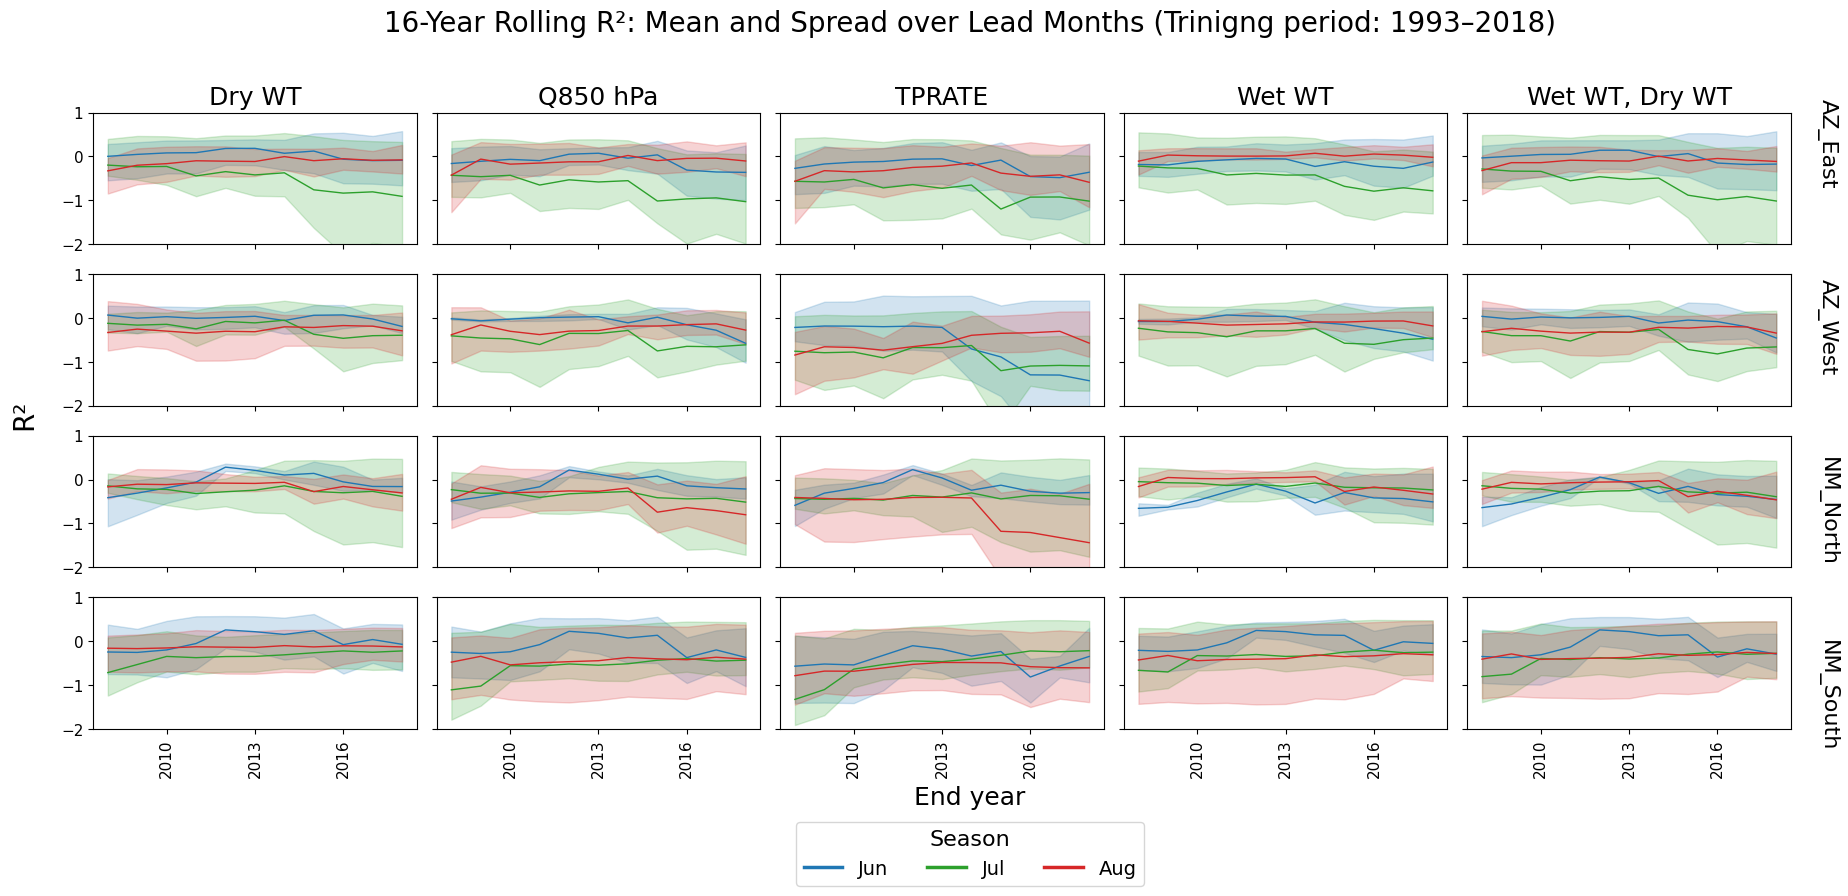

In [24]:
from matplotlib.ticker import MultipleLocator

# Define color palette for seasons
season_colors = {
    "Jun": "#1f77b4",  # Blue
    "Jul": "#2ca02c",  # Green
    "Aug": "#d62728"   # Red
}

regions = sorted(r2_df["region"].unique())
predictors = sorted(r2_df["predictor"].unique())
fig, axes = plt.subplots(len(regions), len(predictors), figsize=(22, 9), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Add region labels aligned with the center of the rightmost subplot axes
for i, region in enumerate(regions):
    ax_right = axes[i, -1]  # Last column in the current row
    pos = ax_right.get_position()
    y_center = (pos.y0 + pos.y1) / 2
    fig.text(pos.x1 - 0.015, y_center, region, va='center', ha='left', fontsize=16, rotation=270)

# Plotting loop
for i, region in enumerate(regions):
    for j, predictor in enumerate(predictors):
        ax = axes[i, j]
        sub_df = r2_df[(r2_df["region"] == region) & (r2_df["predictor"] == predictor)]

        for season in ["Jun", "Jul", "Aug"]:
            season_df = sub_df[sub_df["season"] == season]
            if season_df.empty:
                continue

            pivot = season_df.pivot(index="end_year", columns="lead_month", values="r2")
            pivot.index = pd.to_numeric(pivot.index, errors="coerce")
            pivot = pivot.dropna().apply(pd.to_numeric, errors="coerce").dropna()

            mean_r2 = pivot.mean(axis=1)
            min_r2 = pivot.min(axis=1)
            max_r2 = pivot.max(axis=1)

            ax.plot(pivot.index, mean_r2, label=season, color=season_colors[season], linewidth=1)
            ax.fill_between(pivot.index, min_r2, max_r2, color=season_colors[season], alpha=0.2)

        if i == 0:
            ax.set_title(predictor, fontsize=18)
        ax.tick_params(labelsize=11)
        ax.set_ylim(-2, 1)

        # Only apply tick formatting to bottom row
        if i == len(regions) - 1:
            ax.xaxis.set_major_locator(MultipleLocator(3))
            for tick in ax.get_xticklabels():
                tick.set_rotation(90)


# Shared x-axis and y-axis labels
fig.text(0.5, 0.075, "End year", ha='center', va='center', fontsize=18)

fig.text(0.07, 0.5, "R²", va='center', ha='center', rotation='vertical', fontsize=20)


# Legend moved lower
handles = [plt.Line2D([0], [0], color=color, lw=2.5, label=season) for season, color in season_colors.items()]
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.035), ncol=3, fontsize=14,
           title="Season", title_fontsize=16)

# Main title
plt.suptitle(
    f"16-Year Rolling R²: Mean and Spread over Lead Months (Trinigng period: {min_year}–{max_year})",
    fontsize=20,
    y=0.95
)

plt.tight_layout(rect=[0.08, 0.08, 0.88, 0.93])
plt.show()


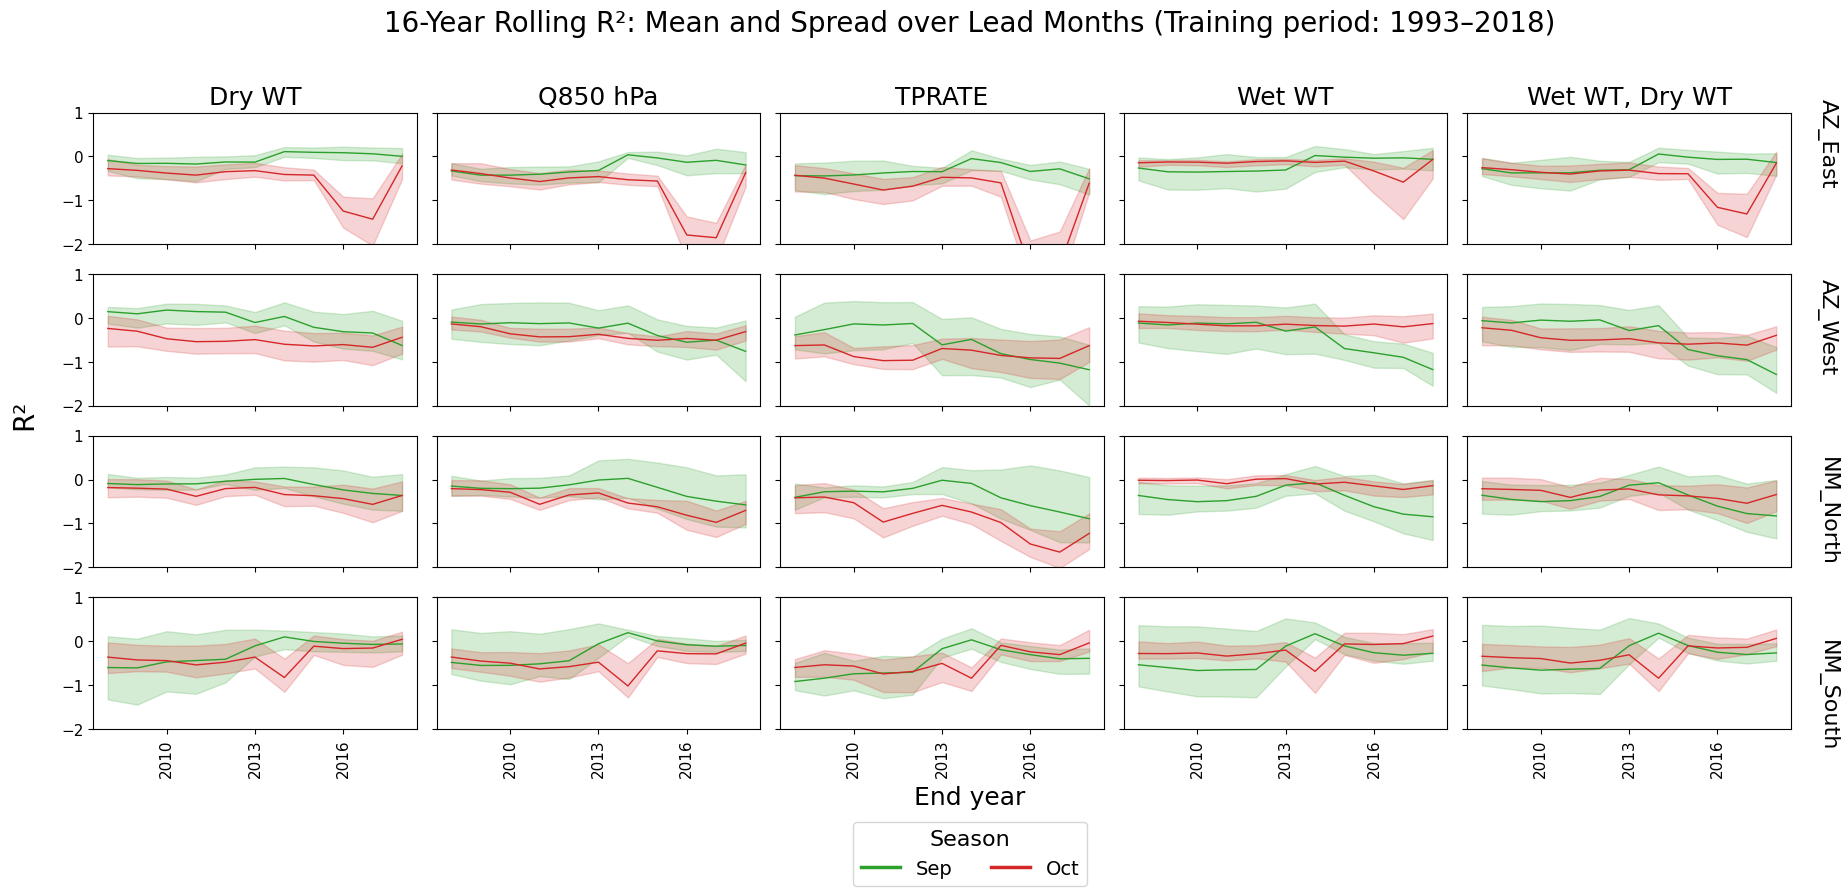

In [25]:
from matplotlib.ticker import MultipleLocator

# Define color palette for seasons
season_colors = {
    "Sep": "#2ca02c",  # Green
    "Oct": "#d62728"   # Red
}

regions = sorted(r2_df["region"].unique())
predictors = sorted(r2_df["predictor"].unique())
fig, axes = plt.subplots(len(regions), len(predictors), figsize=(22, 9), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Add region labels aligned with the center of the rightmost subplot axes
for i, region in enumerate(regions):
    ax_right = axes[i, -1]  # Last column in the current row
    pos = ax_right.get_position()
    y_center = (pos.y0 + pos.y1) / 2
    fig.text(pos.x1 - 0.015, y_center, region, va='center', ha='left', fontsize=16, rotation=270)

# Plotting loop
for i, region in enumerate(regions):
    for j, predictor in enumerate(predictors):
        ax = axes[i, j]
        sub_df = r2_df[(r2_df["region"] == region) & (r2_df["predictor"] == predictor)]

        for season in ["Sep", "Oct"]:
            season_df = sub_df[sub_df["season"] == season]
            if season_df.empty:
                continue

            pivot = season_df.pivot(index="end_year", columns="lead_month", values="r2")
            pivot.index = pd.to_numeric(pivot.index, errors="coerce")
            pivot = pivot.dropna().apply(pd.to_numeric, errors="coerce").dropna()

            mean_r2 = pivot.mean(axis=1)
            min_r2 = pivot.min(axis=1)
            max_r2 = pivot.max(axis=1)

            ax.plot(pivot.index, mean_r2, label=season, color=season_colors[season], linewidth=1)
            ax.fill_between(pivot.index, min_r2, max_r2, color=season_colors[season], alpha=0.2)

        if i == 0:
            ax.set_title(predictor, fontsize=18)
        ax.tick_params(labelsize=11)
        ax.set_ylim(-2, 1)

        # Only apply tick formatting to bottom row
        if i == len(regions) - 1:
            ax.xaxis.set_major_locator(MultipleLocator(3))
            for tick in ax.get_xticklabels():
                tick.set_rotation(90)


# Shared x-axis and y-axis labels
fig.text(0.5, 0.075, "End year", ha='center', va='center', fontsize=18)

fig.text(0.07, 0.5, "R²", va='center', ha='center', rotation='vertical', fontsize=20)


# Legend moved lower
handles = [plt.Line2D([0], [0], color=color, lw=2.5, label=season) for season, color in season_colors.items()]
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.035), ncol=3, fontsize=14,
           title="Season", title_fontsize=16)

# Main title
plt.suptitle(
    f"16-Year Rolling R²: Mean and Spread over Lead Months (Training period: {min_year}–{max_year})",
    fontsize=20,
    y=0.95
)

plt.tight_layout(rect=[0.08, 0.08, 0.88, 0.93])
plt.show()


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load and preprocess GOF data ---
file_path = "gof_training_hindcast_final.csv"
gof_df = pd.read_csv(file_path, engine="python")

# Step 2: Drop training rows (missing lead_month)
gof_filtered = gof_df[gof_df["lead_month"].notna()].copy()

# Step 3: Drop rows missing essential fields
gof_filtered.dropna(subset=["region", "season", "lead_month", "value"], inplace=True)

# Step 4: Ensure proper types and fill missing columns
gof_filtered["lead_month"] = gof_filtered["lead_month"].astype(int)

if "predictor" not in gof_filtered.columns:
    gof_filtered["predictor"] = "default"

if "model" not in gof_filtered.columns:
    gof_filtered["model"] = "unknown"

# Step 5: Custom season order
custom_season_order = ['Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                       'JJ', 'JA', 'AS', 'SO',
                       'JJA', 'JAS', 'ASO', 'JASO', 'JJASO']
gof_filtered["season"] = pd.Categorical(gof_filtered["season"],
                                        categories=custom_season_order,
                                        ordered=True)

# --- Step 6: Predictor name mapping ---
predictor_label_map = {
    'ant_dsst3.4_for': "dSST3.4",
    'ant_mei_for': "MEI",
    'ant_soi_for': "SOI",
    "sumDry_for": "Dry WT",
    "sumMonsoon_for": "Wet WT",
    "sumq_for": "Q850 hPa",
    "antecedent_3m_for": "AntecedPR_3m",
    "antecedent_1m_for": "AntecedPR_1m",
    "sumtclw_for": "TCLW",
    "sumtprate_for": "TPRATE",
    "sumMonsoon_for+sumDry_for": "Wet WT, Dry WT",
    "sumMonsoon_for+sumDry_for+antecedent_3m_for": "Wet WT, Dry WT, AntecedPR_3m",
    "sumq_for+antecedent_3m_for": "Q850 hPa, AntecedPR_3m"
}

**7.1. BSS and RPSS Heatmaps**

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

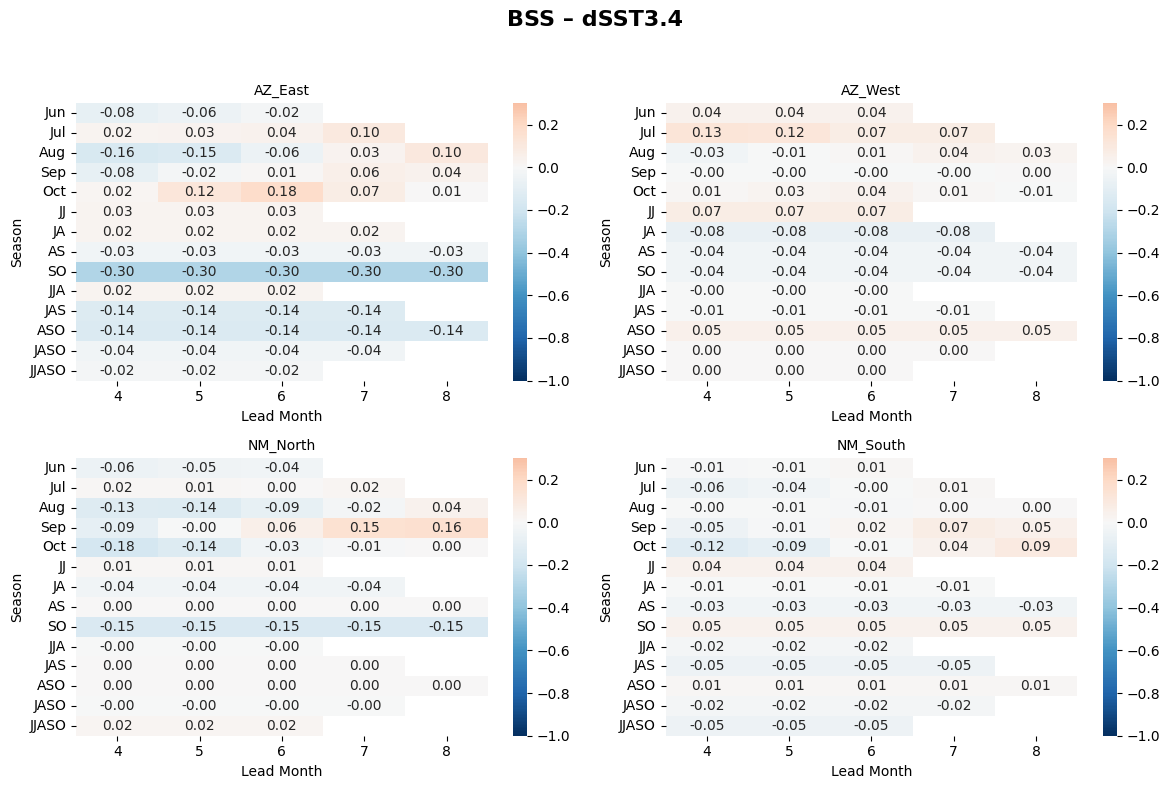

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

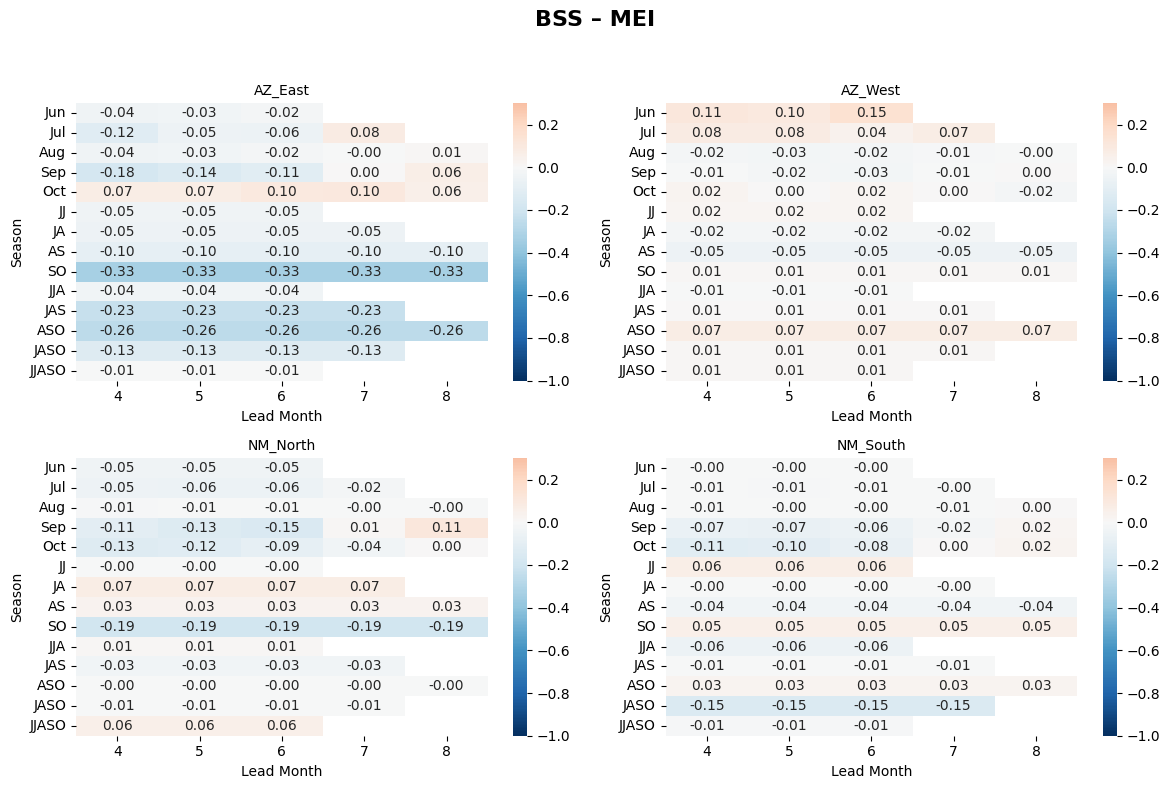

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

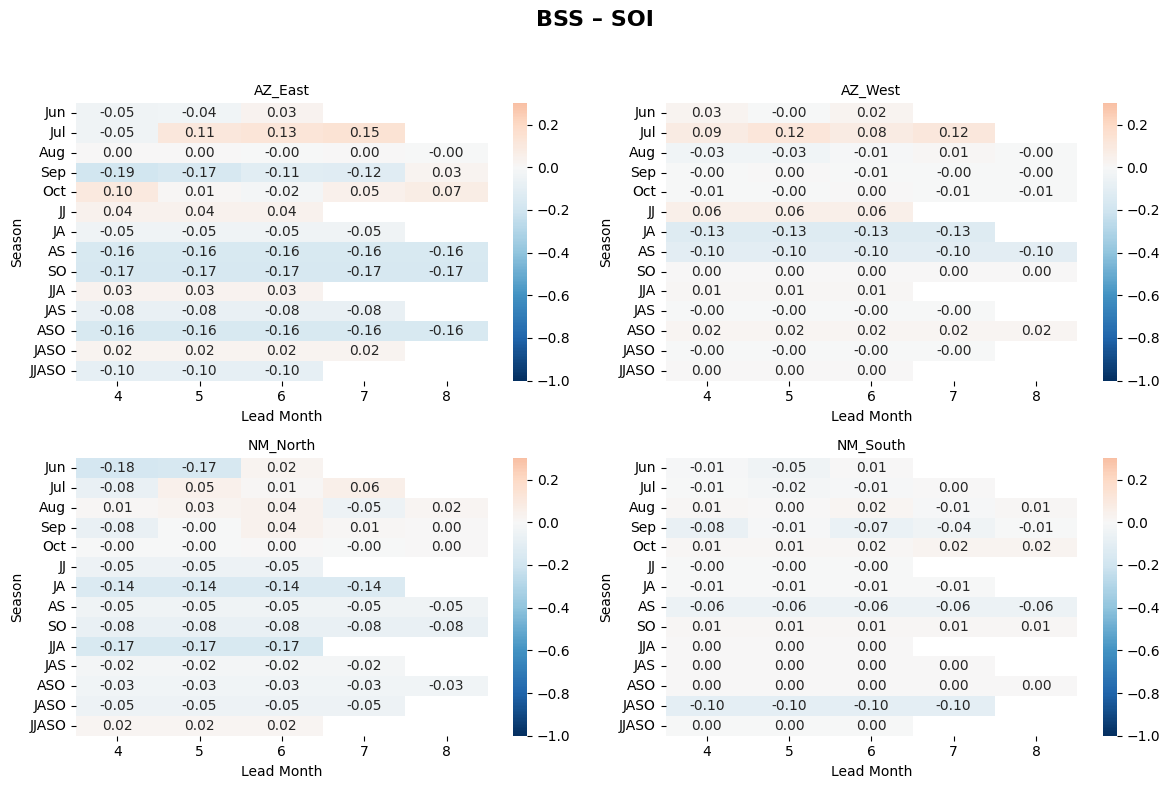

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

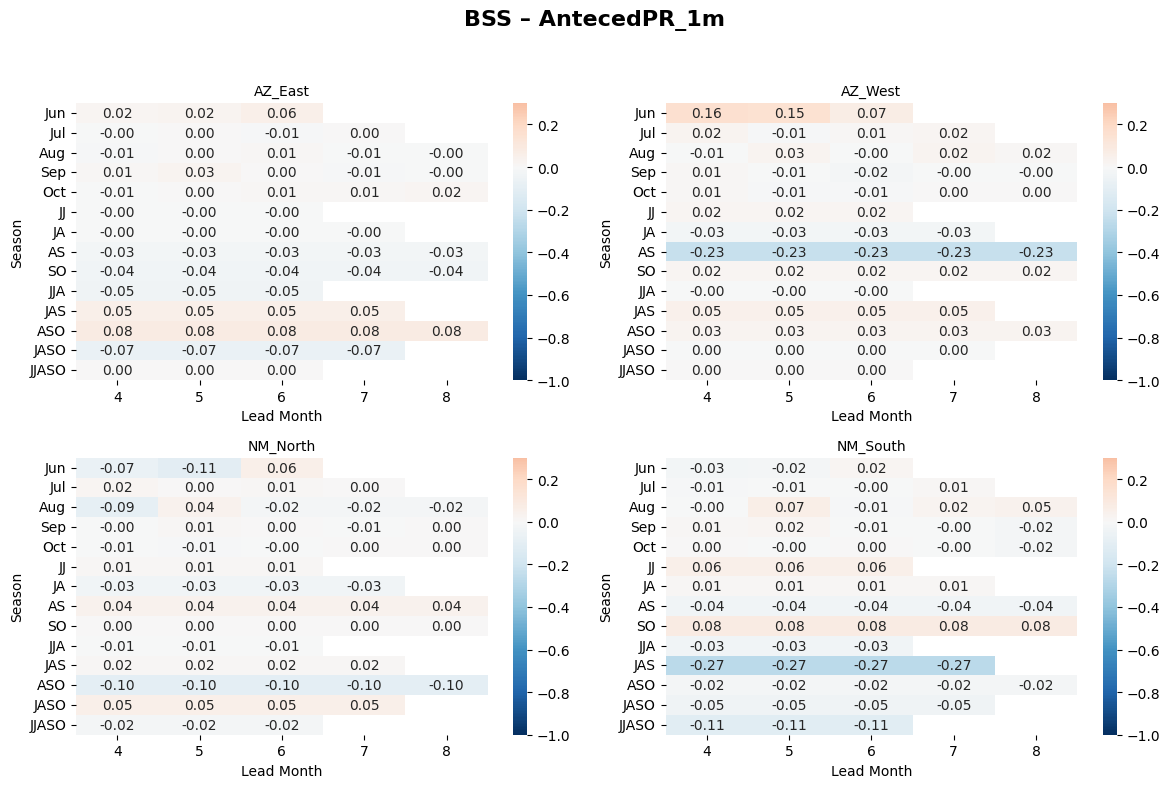

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

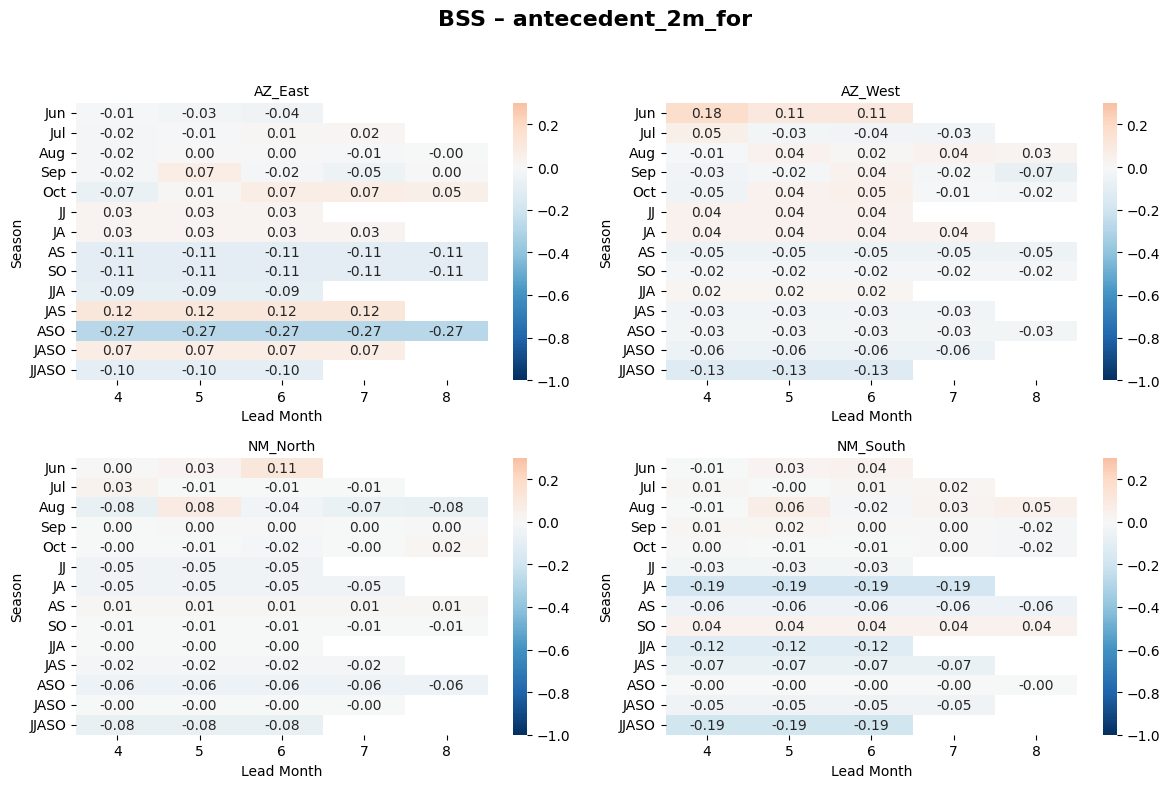

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

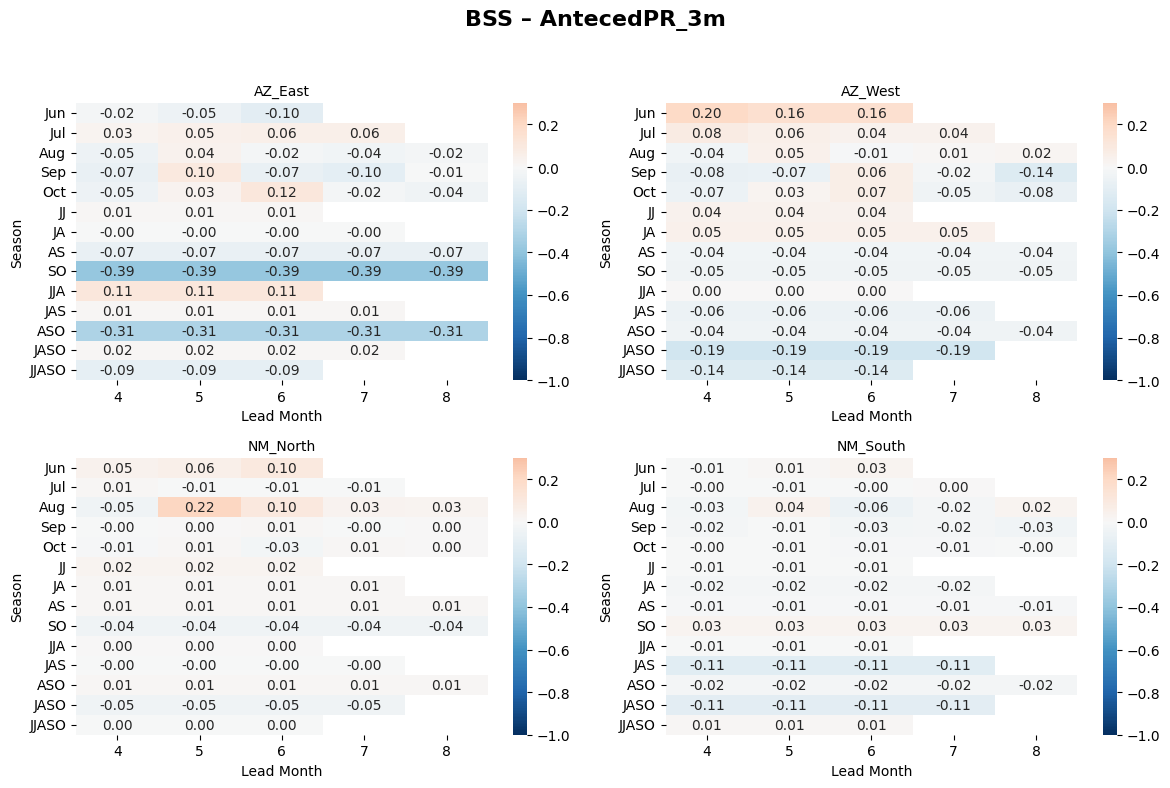

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

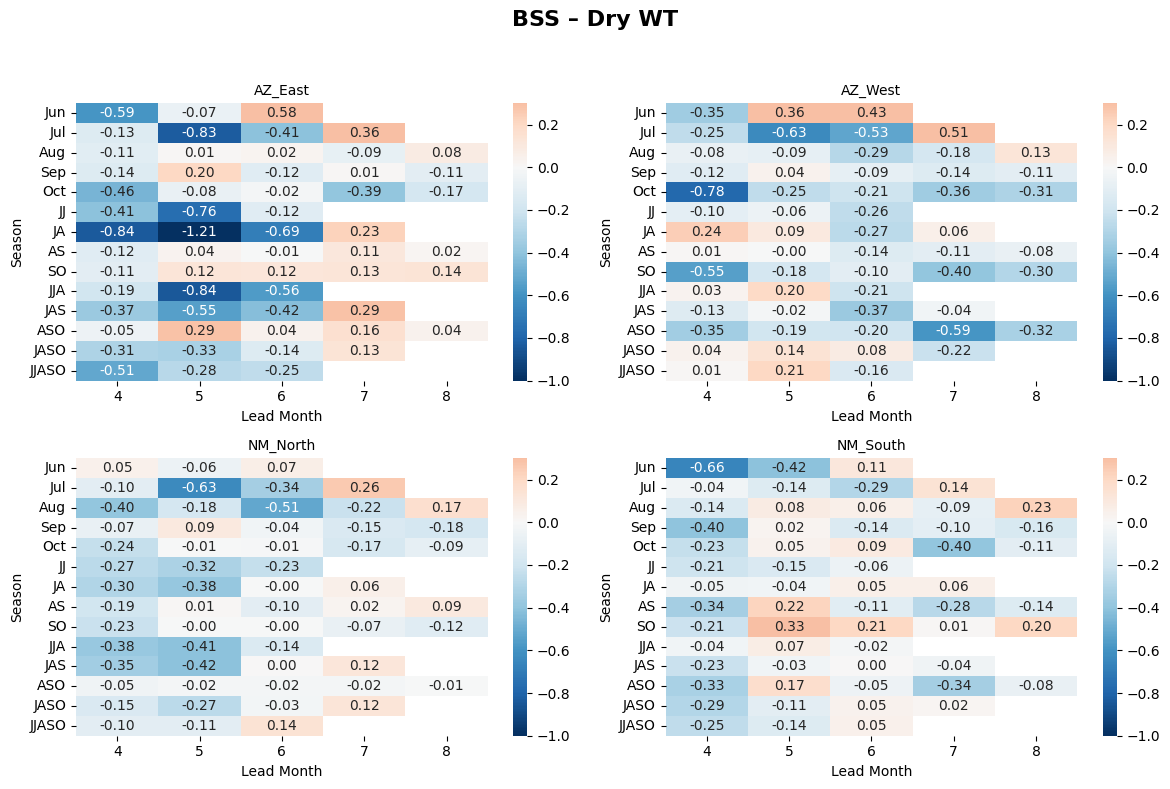

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

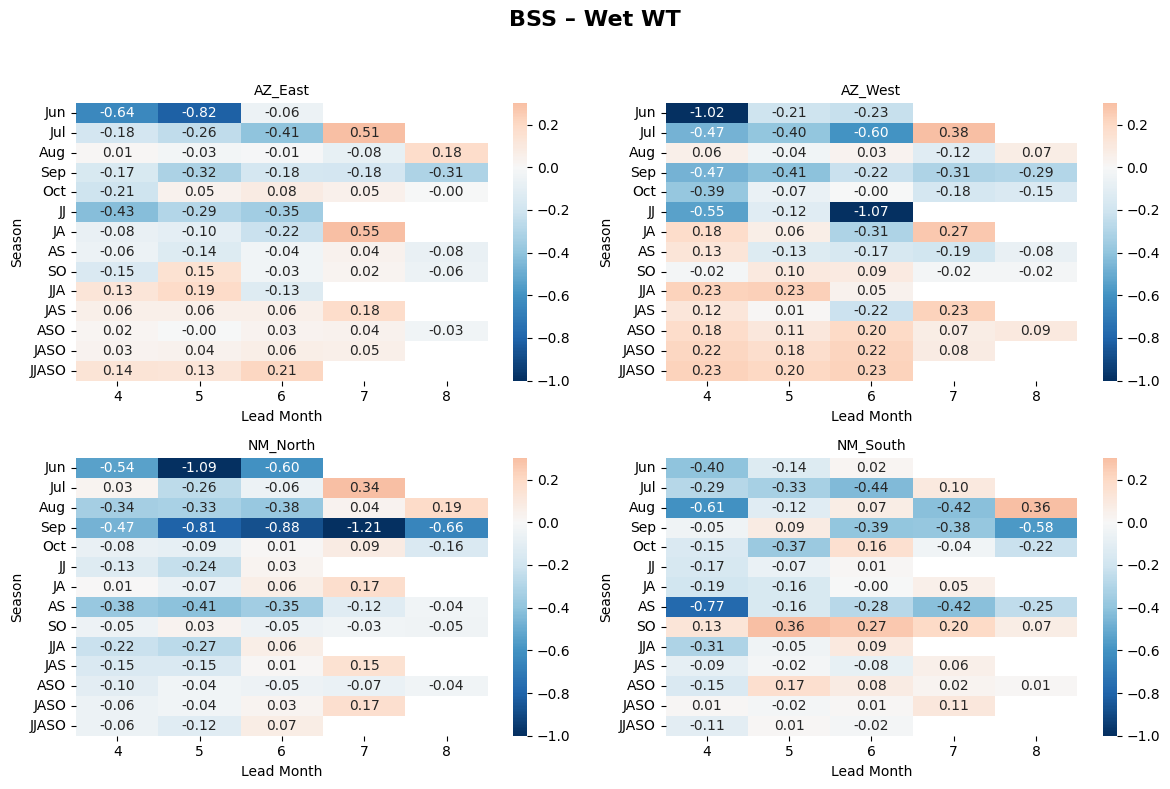

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

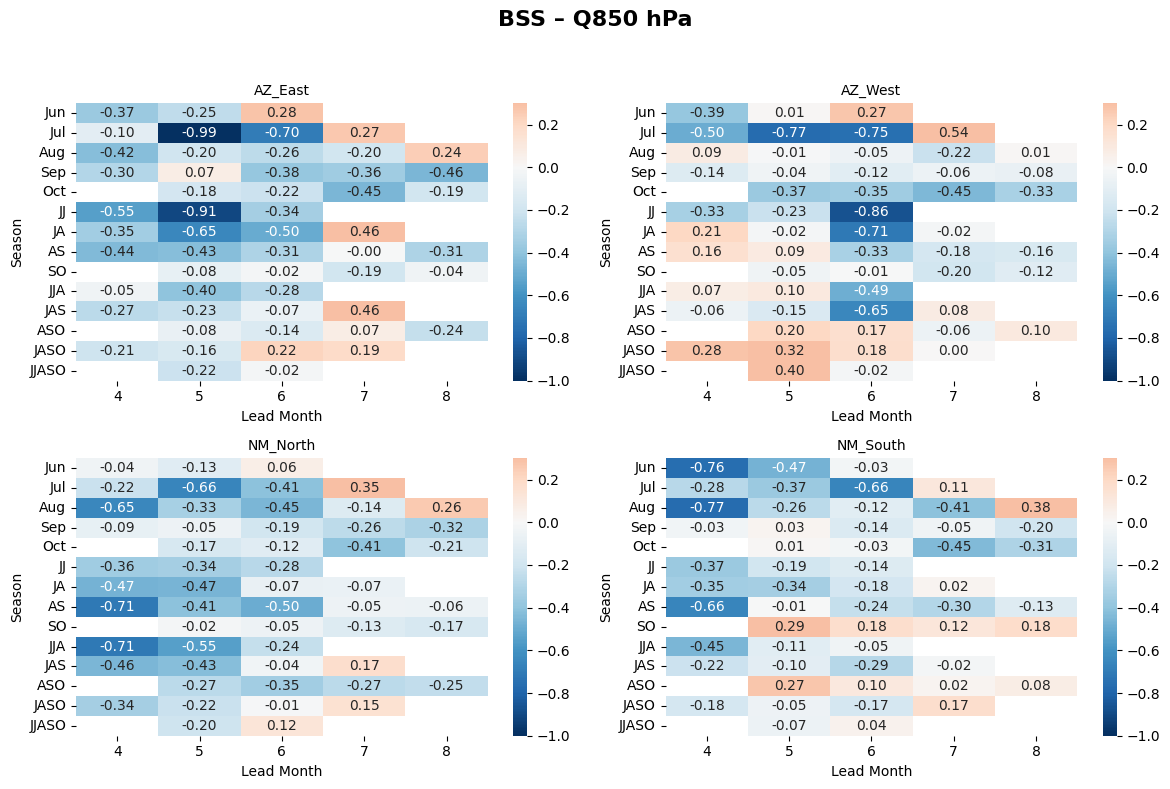

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

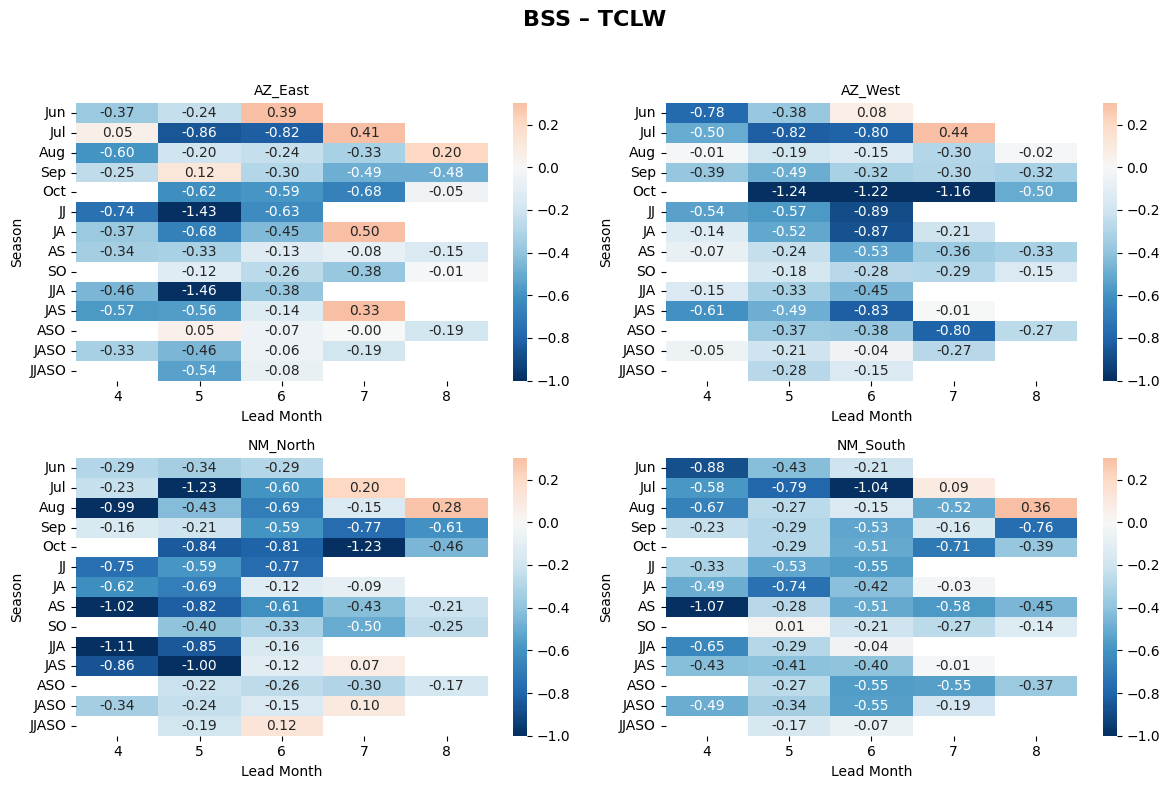

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

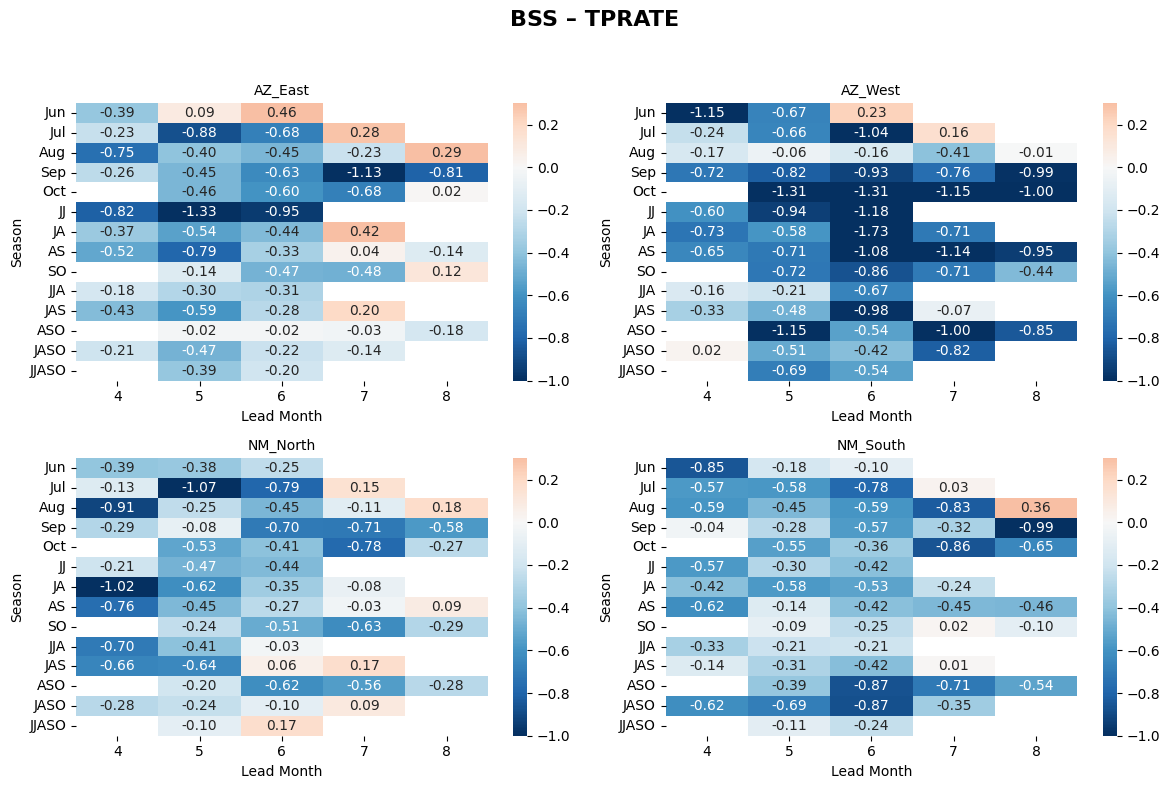

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

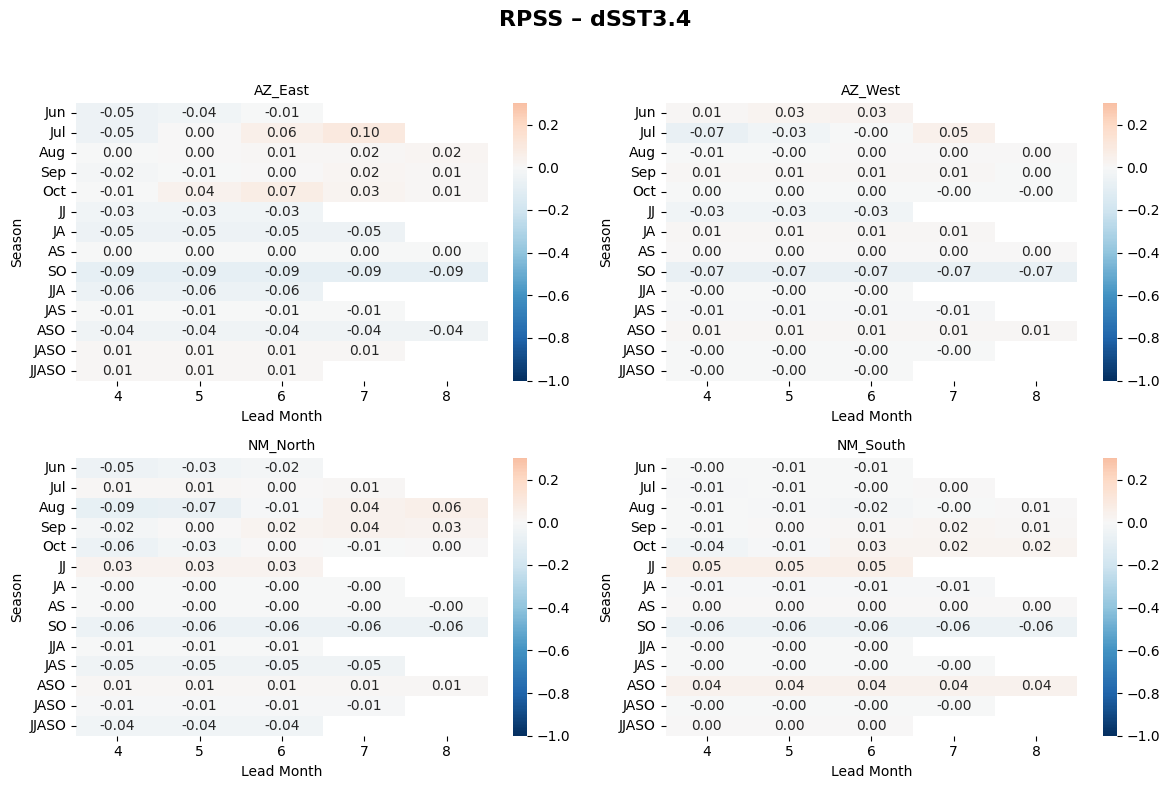

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

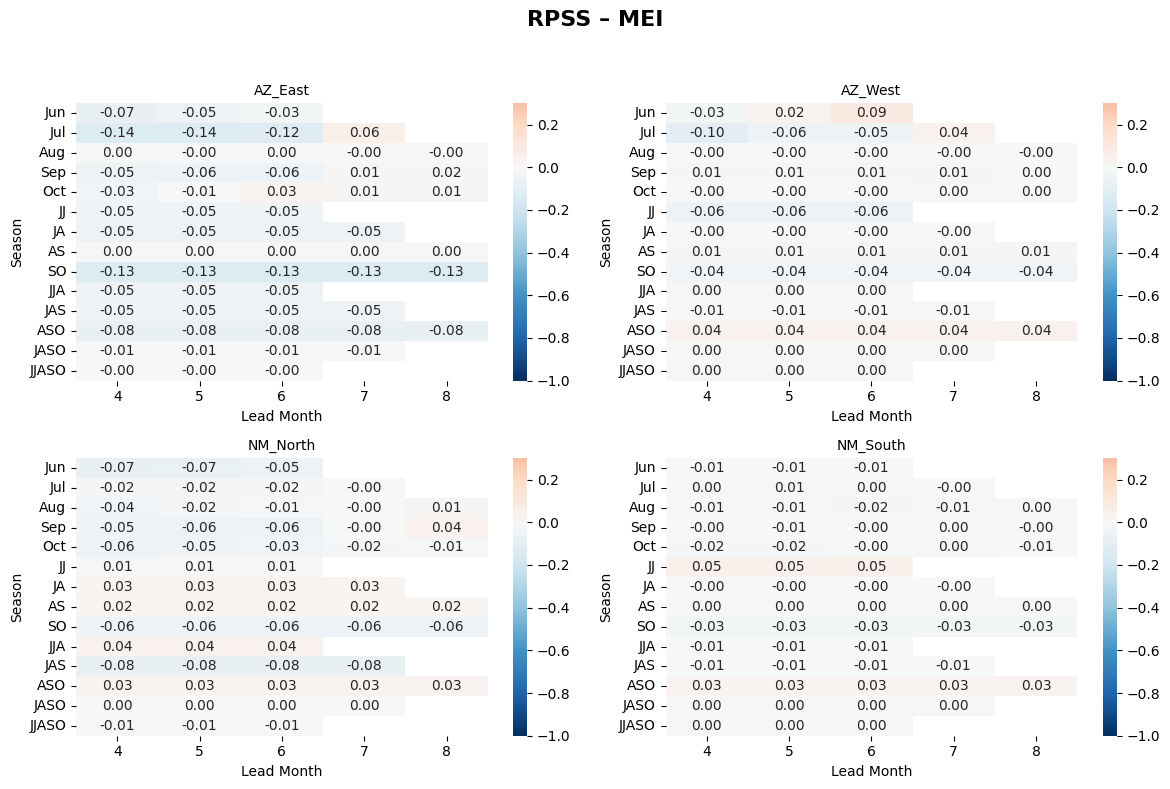

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

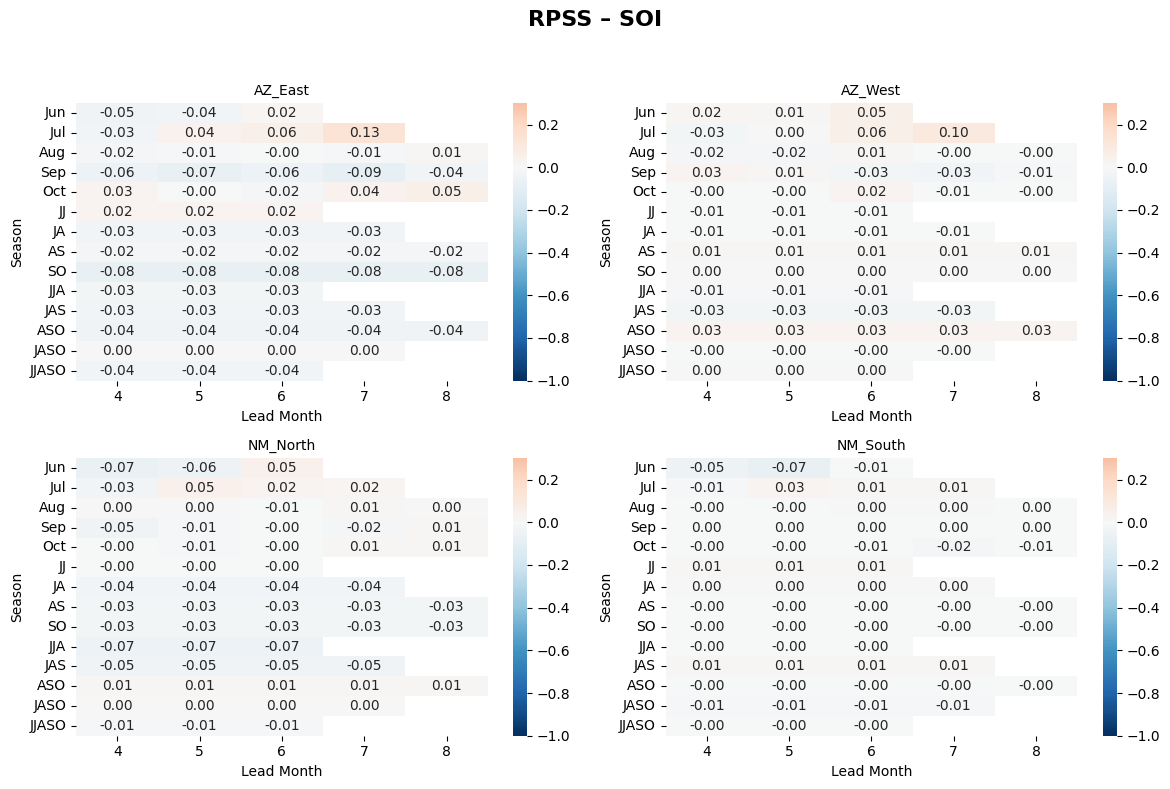

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

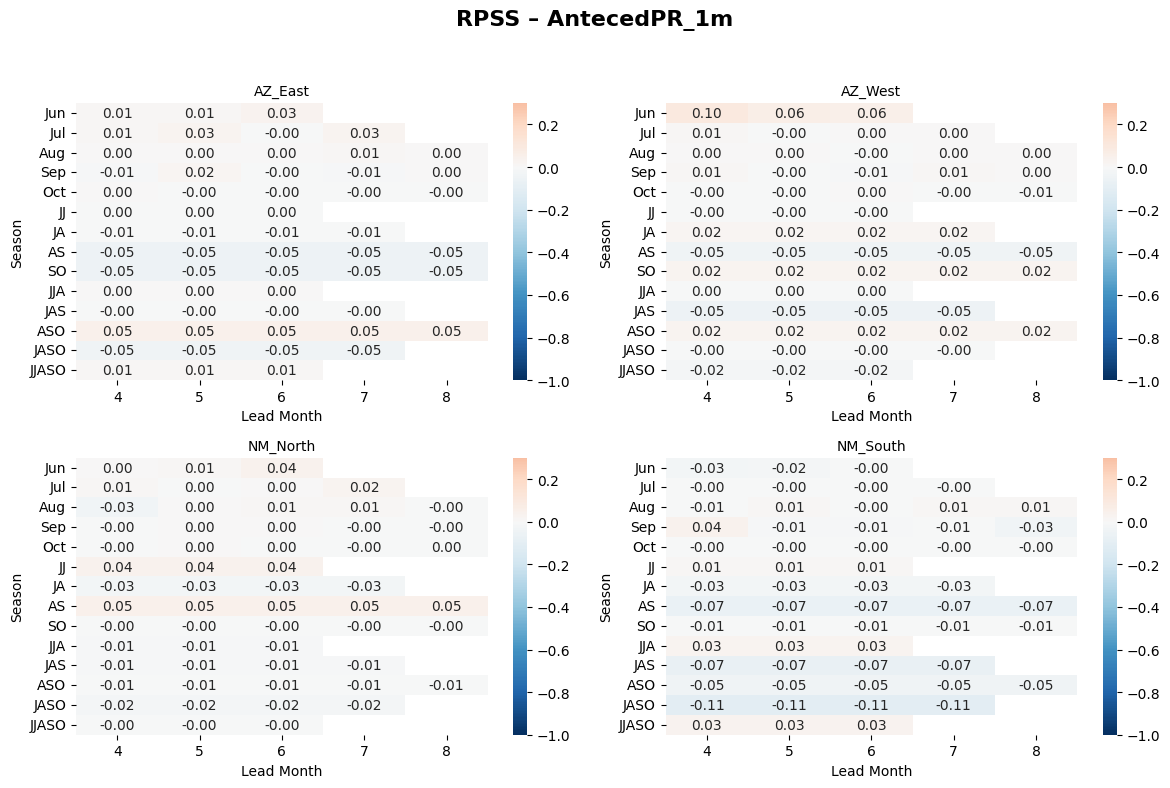

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

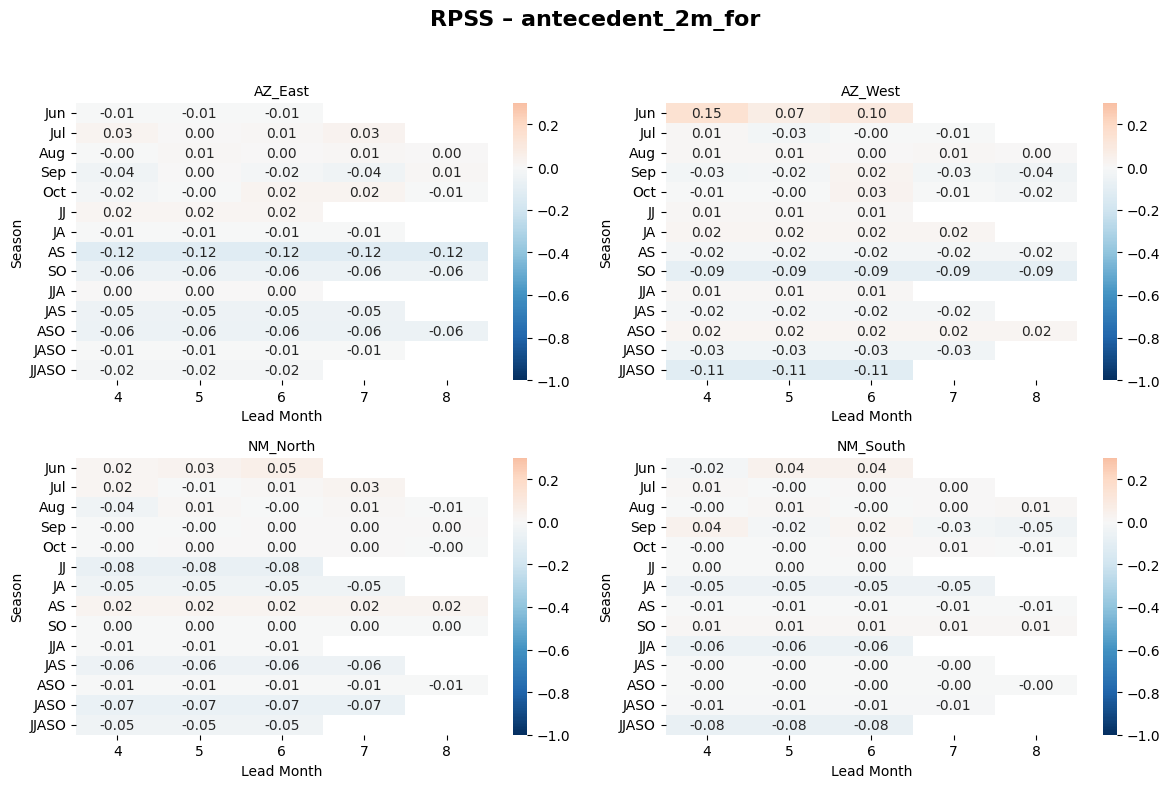

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

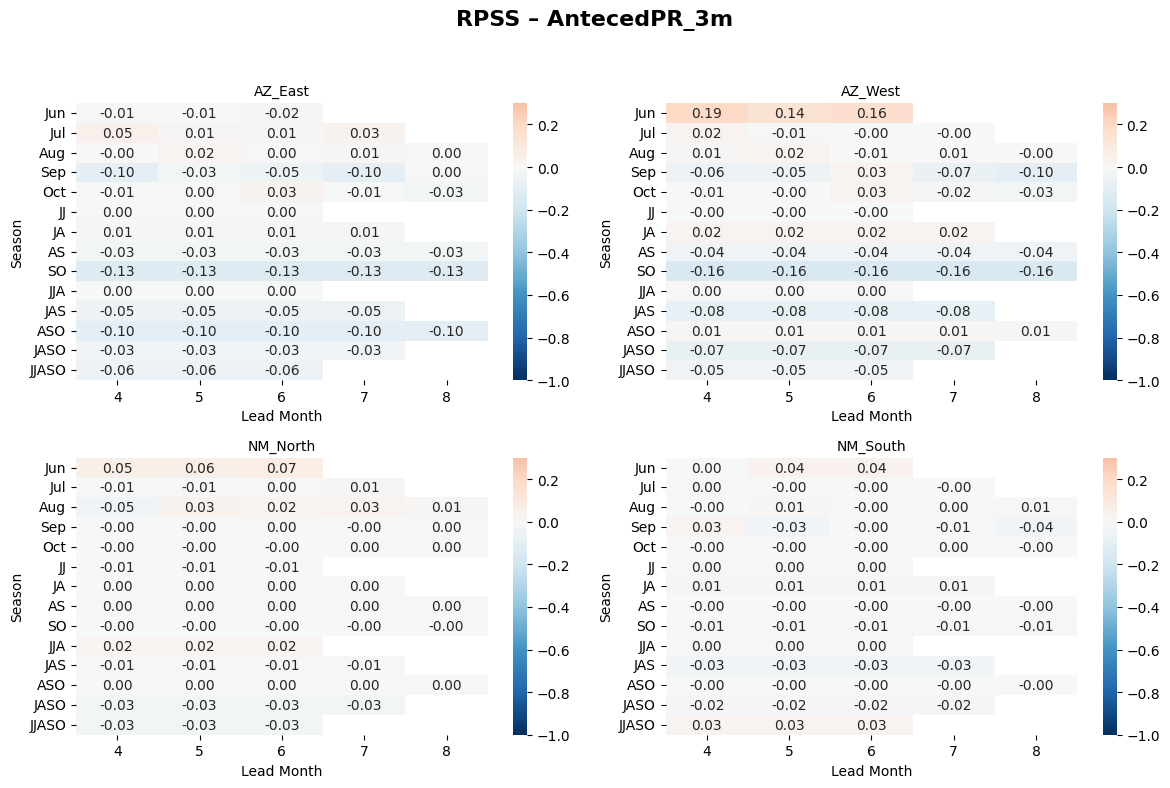

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

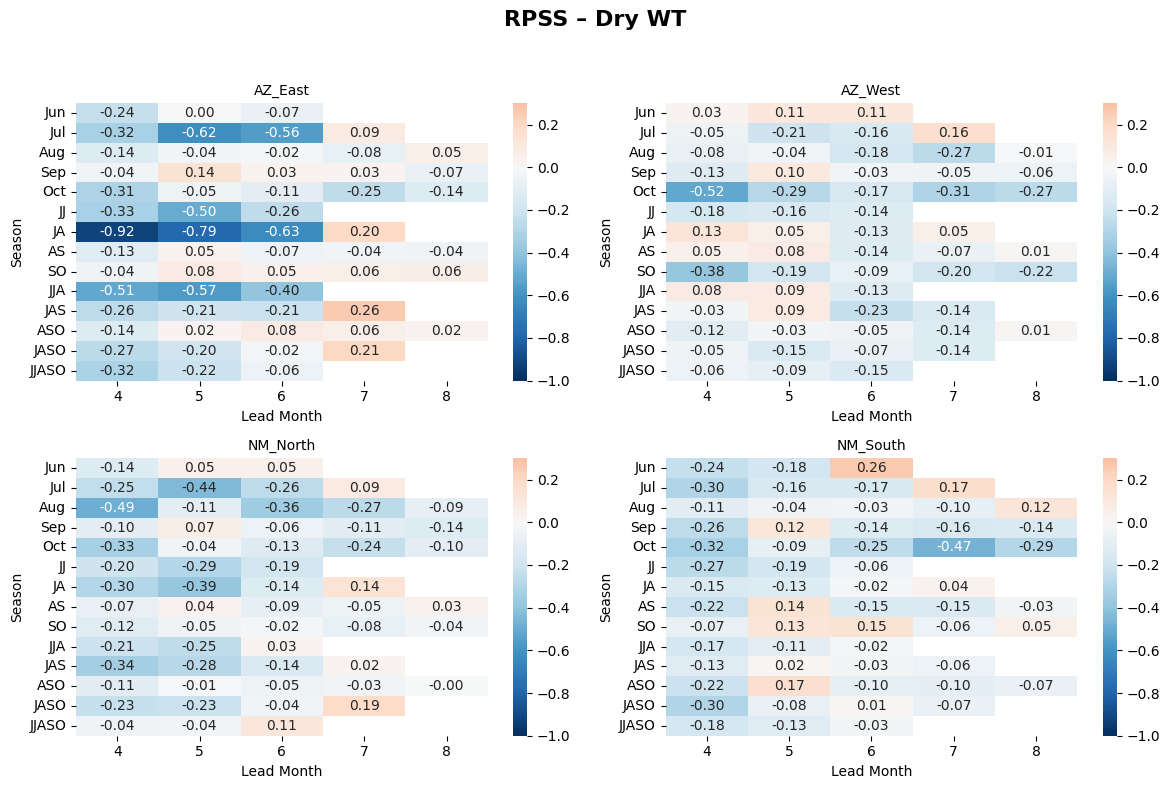

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

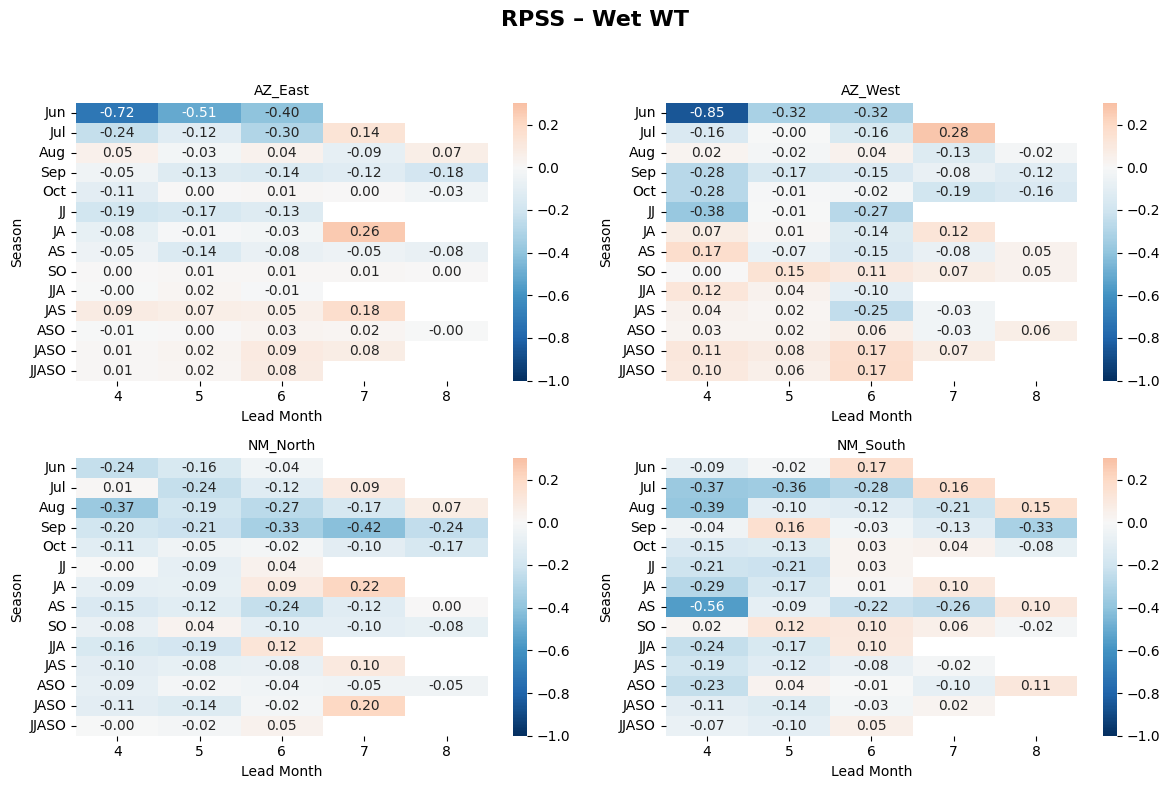

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

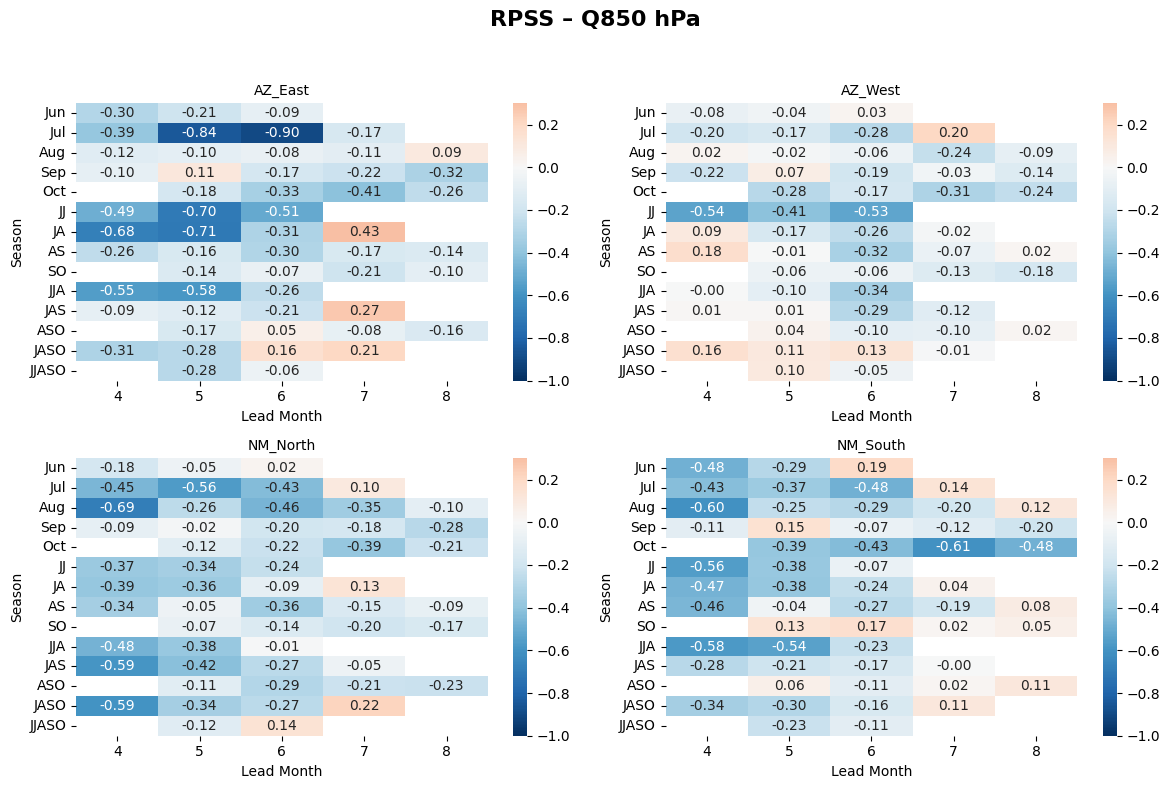

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

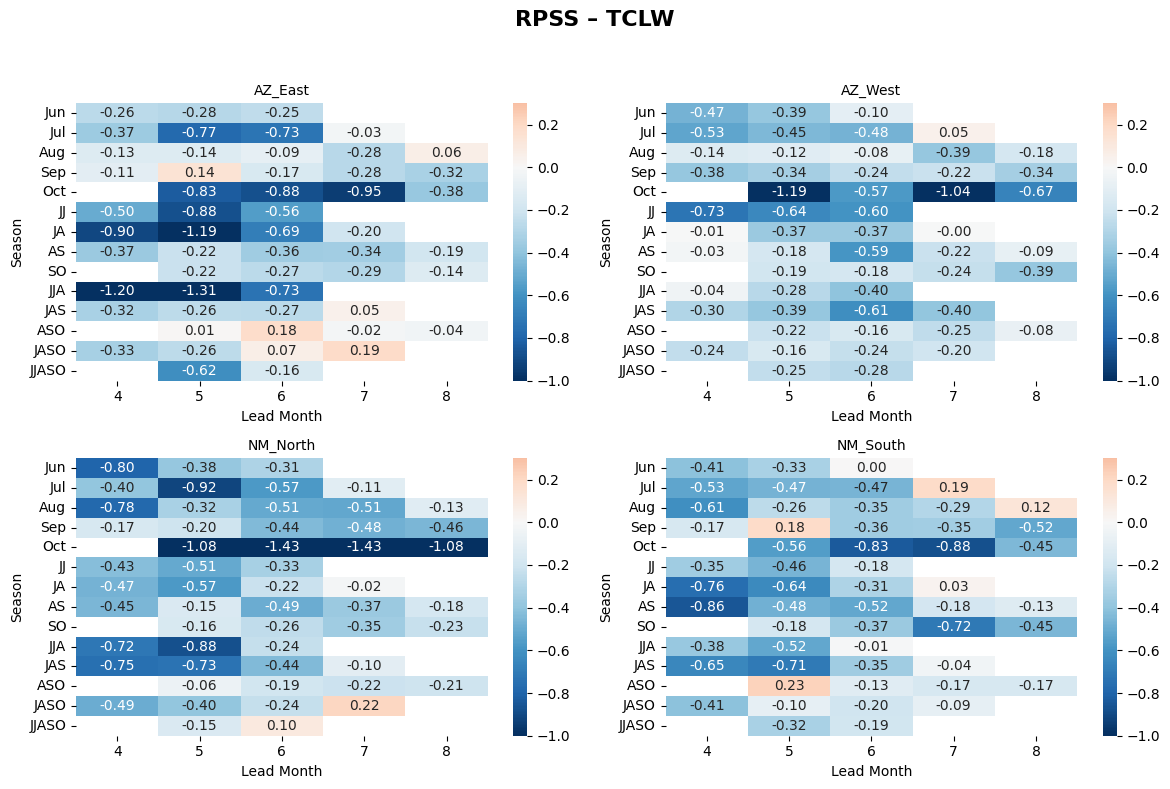

/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
/tmp/ipython-input-27-3045143780.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", c

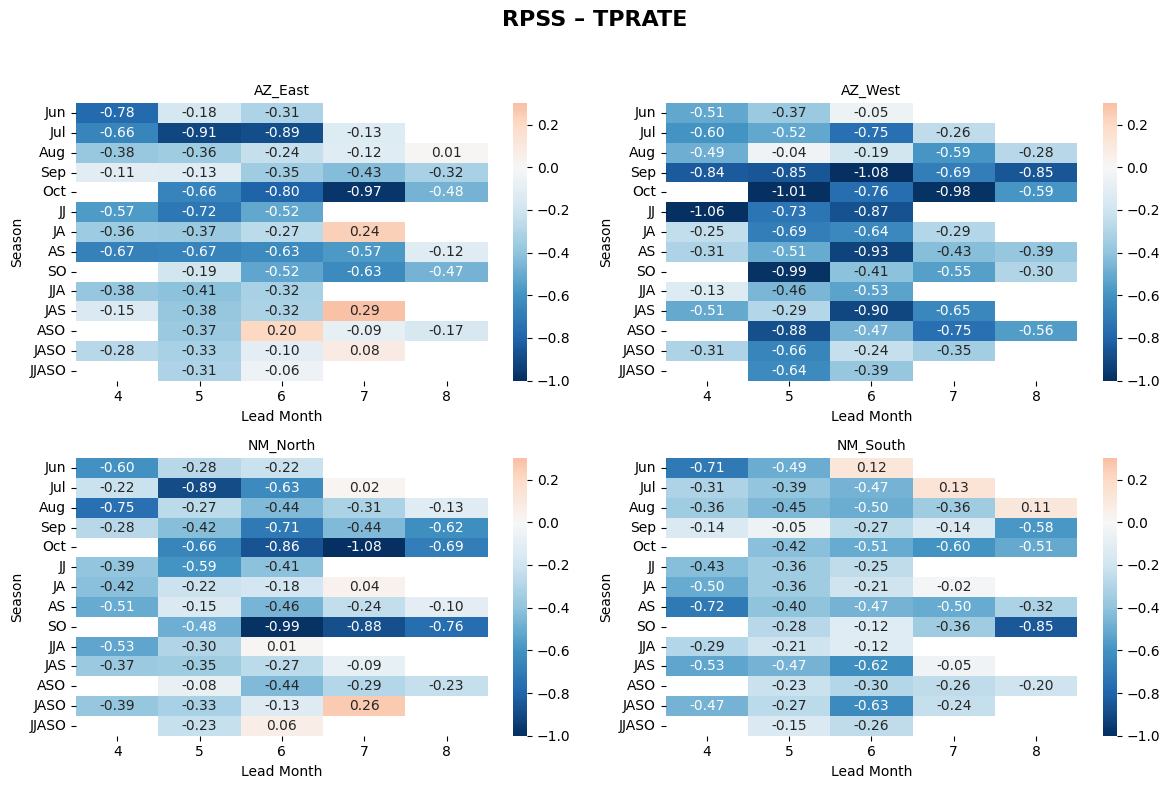

In [27]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Assume these are already defined:
# custom_season_order, predictor_label_map, gof_filtered
stats_to_plot = ["BSS", "RPSS"]
predictors = sorted(gof_filtered["predictor"].dropna().unique())

regions_all = sorted(gof_filtered["region"].dropna().unique())

for stat in stats_to_plot:
    for predictor in predictors:
        df_pred = gof_filtered[
            (gof_filtered["predictor"] == predictor) &
            (gof_filtered["stat"] == stat)
        ]

        regions = sorted(df_pred["region"].dropna().unique())
        n_regions = len(regions)
        n_cols = 2
        n_rows = math.ceil(n_regions / n_cols)

        # Split regions into chunks of 4 (2x2)
        for i in range(0, n_regions, 4):
            region_chunk = regions[i:i+4]
            n_sub = len(region_chunk)
            nrows = 2
            ncols = 2

            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
            axes = axes.flatten()

            for j, region in enumerate(region_chunk):
                ax = axes[j]
                df_region = df_pred[df_pred["region"] == region]

                matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
                matrix = matrix.reindex(custom_season_order)

                sns.heatmap(matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                            vmin=-1, vmax=0.3, ax=ax)
                ax.set_title(f"{region}", fontsize=10)
                ax.set_xlabel("Lead Month")
                ax.set_ylabel("Season")

            # Hide unused subplots if < 4
            for k in range(n_sub, len(axes)):
                axes[k].axis('off')

            friendly_name = predictor_label_map.get(predictor, predictor)
            fig.suptitle(f"{stat} – {friendly_name}", fontsize=16, fontweight='bold')

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

**7.2. R2 heatmaps for the SLR and MRL predictions**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.gridspec as gridspec

stat_to_plot = "R2"
predictors = sorted(gof_filtered["predictor"].dropna().unique())

regions = sorted(gof_filtered["region"].dropna().unique())
n_rows = 2
n_cols = 2

for predictor in predictors:
    df_pred = gof_filtered[
        (gof_filtered["predictor"] == predictor) &
        (gof_filtered["stat"] == stat_to_plot)
    ]

    if df_pred.empty:
        continue

    friendly_name = predictor_label_map.get(predictor, predictor)

    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f"{friendly_name}", fontsize=16, fontweight='bold')

    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(n_rows, n_cols + 1, width_ratios=[1, 1, 0.05])

    axes = []
    for i in range(n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        ax = fig.add_subplot(gs[row, col])
        axes.append(ax)

    cbar_ax = fig.add_subplot(gs[:, -1])

    for ax, region in zip(axes, regions):
        df_region = df_pred[df_pred["region"] == region]
        if df_region.empty:
            ax.axis("off")
            continue

        matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
        matrix = matrix.reindex(custom_season_order)

        sns.heatmap(matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                    vmin=-1, vmax=0.3, ax=ax, cbar_ax=cbar_ax, cbar=True)

        ax.set_title(region)
        ax.set_xlabel("Lead Month", fontsize=13)
        ax.set_ylabel("Season", fontsize=13)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

**7.3. BSS and RPSS Boxplots**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Define the predictors of interest
target_predictors = [
    "antecedent_3m_for", "antecedent_1m_for", "ant_dsst3.4_for", "sumDry_for",
    "sumMonsoon_for", "sumq_for", "sumtclw_for", "sumtprate_for"
]

# Filter and prepare the data
box_df = gof_filtered[
    (gof_filtered["predictor"].isin(target_predictors)) &
    (gof_filtered["lead_month"].notna())  # Hindcast only
].copy()

box_df["predictor_label"] = box_df["predictor"].map(predictor_label_map)
box_df["season_lead"] = box_df["season"].astype(str) + "_L" + box_df["lead_month"].astype(str)

# Drop rows with missing mapping
box_df.dropna(subset=["predictor_label", "season_lead", "value"], inplace=True)

palette = sns.color_palette("Set2", len(target_predictors))

# Define the regions and stats
regions = sorted(box_df["region"].unique())
stats = ["BSS", "RPSS"]


# Loop over stats
for stat in stats:
    df_plot = box_df[box_df["stat"] == stat]

    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # Boxplot: group by region, hue by predictor
    sns.boxplot(
        data=df_plot,
        x="region",
        y="value",
        hue="predictor_label",
        palette=palette,
        ax=ax
    )

    # Overlay jittered points
    sns.stripplot(
        data=df_plot,
        x="region",
        y="value",
        hue="predictor_label",
        dodge=True,
        jitter=0.25,
        marker='.',
        alpha=0.4,
        palette=palette,
        linewidth=0.5,
        ax=ax
    )

    # Fix duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    n_predictors = len(target_predictors)
    ax.legend(handles[:n_predictors], labels[:n_predictors],
              title="Predictor", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Formatting
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.title(f"{stat} Skill Score (Hindcast)")
    plt.xlabel("Region")
    plt.ylabel(stat)
    plt.tight_layout()
    plt.show()


In [ ]:
print(gof_filtered["model"].unique())

**7.4. RMSE Skill Scores Relative to Climatology for SLR and MLR Models**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Load the data
gof_filtered = pd.read_csv("gof_training_hindcast_final.csv")

# Define label map
predictor_map = {
    #'ant_dsst3.4_for': "dSST3.4",
    "sumDry_for": "Dry WT",
    "sumMonsoon_for": "Monsoon WT",
    "sumq_for": "Q850 hPa",
    #"antecedent_3m_for": "AntecedPR_3m",
    #"antecedent_1m_for": "AntecedPR_1m",
    "sumtclw_for": "TCLW",
    "sumtprate_for": "TPRATE",
    "sumMonsoon_for+sumDry_for": "Monsoon WT, Dry WT",
    "sumMonsoon_for+sumDry_for+antecedent_3m_for": "Monsoon WT, Dry WT, AntecedPR_3m",
    "sumq_for+antecedent_3m_for": "Q850 hPa, AntecedPR_3m"
}

ordered_labels = [
    "Monsoon WT, Dry WT",
    "Monsoon WT, Dry WT, AntecedPR_3m",
    "Q850 hPa",
    "TCLW",
    "TPRATE",
    "Q850 hPa, AntecedPR_3m",
    "Dry WT",
    "Monsoon WT"
]

target_predictors = list(predictor_map.keys())
# Filter relevant rows
rmse_data = gof_filtered[
    (gof_filtered["stat"] == "RMSE") &
    (gof_filtered["predictor"].isin(target_predictors)) &
    (gof_filtered["lead_month"].notna()) &
    (gof_filtered["model"].isin(["SLR", "MLR", "climatology"]))
].copy()

# Pivot to get RMSE for each model
pivot_df = rmse_data.pivot_table(
    index=["predictor", "region", "season", "lead_month"],
    columns="model",
    values="value"
).reset_index()

# Compute skill score
pivot_df["rmse_model"] = pivot_df[["SLR", "MLR"]].min(axis=1)
pivot_df["delta_rmse"] = pivot_df["climatology"] - pivot_df["rmse_model"]
pivot_df["rmse_skill_score"] = 1 - pivot_df["rmse_model"] / pivot_df["climatology"]

# Map predictor labels
pivot_df["predictor_label"] = pivot_df["predictor"].map(predictor_map)
pivot_df["predictor_label"] = pd.Categorical(
    pivot_df["predictor_label"],
    categories=ordered_labels,
    ordered=True
)

# Plot (grouped by region)
palette = sns.color_palette("Set2", len(ordered_labels))  # One color per predictor
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Boxplot
sns.boxplot(
    data=pivot_df,
    x="region",
    y="rmse_skill_score",
    hue="predictor_label",
    palette=palette,
    ax=ax
)

# Stripplot
sns.stripplot(
    data=pivot_df,
    x="region",
    y="rmse_skill_score",
    hue="predictor_label",
    dodge=True,
    jitter=0.25,
    marker='.',
    alpha=0.5,
    palette=palette,
    linewidth=0.5,
    ax=ax
)

# Legend cleanup
handles, labels = ax.get_legend_handles_labels()
n_predictors = len(ordered_labels)
ax.legend(handles[:n_predictors], labels[:n_predictors],
          title="Predictor", bbox_to_anchor=(1.05, 1), loc='upper left')

# Aesthetic adjustments
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
ax.set_ylim(-0.8, 0.5)
plt.title(r"$(\mathrm{RMSE}_{\mathrm{clim}} - \mathrm{RMSE}_{\mathrm{model}}) \,/\, \mathrm{RMSE}_{\mathrm{clim}}$", fontsize=14)
plt.xlabel("Region")
plt.ylabel("Relative RMSE Improvement")
plt.tight_layout()
plt.show()
pivot_df.to_csv("pivot_df.csv", index=False)